# -----
# FIG 6 in RECCAP SO paper, part 1 (panels a-c)
# -----
# also included: Fig. S2, Fig. S10
#
# Plot seasonality of climatolgical air-sea CO2 flux (ICE/SPSS/STSS; version with 9 regions for the supplement)
# 
# Note: AOML is not considered in multi-data-product mean
# Note: MPI is not shown  
#
# Contact: cara.nissen@awi.de or cara.nissen@colorado.edu
#
# version: August 2023
#

In [2]:
### modules
import os
import numpy as np
import seawater as sw
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import cm 
from datetime import date, timedelta
import copy
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from annualmean import annualmean

In [3]:
#-----
# SETTINGS
# define paths to all data
# define where to save plots (if any)
# define years to average over
#-----

# data sets
path1 = '/pscratch/sd/c/cnissen/RECCAPv2/'
path_models = path1+'reccap_submissions/download_20220124/Models/2D_CO2/' 
path_data   = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_atminv = path1+'reccap_submissions/download_20220124/Atmospheric_inversions/'
path_soccom = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_trend  = path1+'reccap_submissions/download_20220124/Models/Linear_trends/' 

# river flux adjustment
path_river  = path1+'masks_reccap/river_flux_adjustment/'

# path to RECCAP SO mask
path_mask = path1+'masks_reccap/'

#----
# specify years to average over
#----
# NOTE: the script is written to plot avrages over 1985-2018
#    the years are defined here for plot titles and filenames 
year1,year2 = 1985,2018 
eval_time   = np.arange(year1,year2+1) 

#----
# define simulation
#----
sim = 'A'

#----
# define where to save plots
#----
save_to_dir ='/global/cfs/cdirs/m4003/cnissen/Plots/RECCAPv2_SO_Paper/Fig_6/'
if not os.path.exists(save_to_dir):
    print ('Created '+save_to_dir)
    os.makedirs(save_to_dir)
    
#save_to_dir2 =save_to_dir+'individual_maps/'
#if not os.path.exists(save_to_dir2):
#    print ('Created '+save_to_dir2)
#    os.makedirs(save_to_dir2)
    

In [4]:
#-----
# define data sets to consider
#-----
# NOTE: there is 6 different atm. inversions in the provided file, only load the ones that start in 1990 
# NOTE: AOML has to be the first in the list! there is a few places where the exclusion of AOML is 
# hard-coded as "[1:]"

# variable name of interest
var = '2D_CO2'

models     = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ') 
models2     = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SO-ETHZ') 
ind_mpi = models.index("MPIOM-HAMOCC")
ind_not_mpi = [i for i, s in enumerate(models) if 'MPIOM-HAMOCC' not in s]
print ('Index of MPI:',ind_mpi)
print ('All inidces except MPI:',ind_not_mpi)
data_assim  = ('BSOSE','ECCO-Darwin')
data_ocim   = ('OCIM-v2014-CTL','OCIM-v2021')
data_atminv = ['Atm_inv1','Atm_inv2','Atm_inv4']  #'Atm_inv3','Atm_inv5','Atm_inv6' -> start later than 1990
#data_atminv = ['Atm_inv1','Atm_inv2','Atm_inv3','Atm_inv4','Atm_inv5','Atm_inv6'] # for 2015-2018, consider all 6
data_prod   = ('AOML_EXTRAT','CMEMS-LSCE-FFNN','CSIRML6','JenaMLS','JMAMLR',\
             'LDEO-HPD','NIES-ML3','OceanSODAETHZ','SOMFFN') 
data_watson = ['UOEX_Wat20']
soccom      = ('SOCCOM_Jena','SOCCOM_SOMFFN')

versionID_models     = ('20211125','v20211122','v20211208','v20220323','v20211119','v20211119',\
                       'v20220125','v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404','v20220630') 
versionID_data_assim  = ('I134','v20210712')
versionID_data_ocim   = ('v20210607','v20210511')
versionID_data_atminv = ['v20211008']
versionID_data_prod   = ('v20211130','v20210709','v20211117','v20211126','v20211208',\
                       'v20211210','v20220222','v20211207','v20211121')
versionID_data_watson = ['v20211204']

# list of filenames for data products
filename_data_prod = ('fgco2_AOML_EXTRAT_1997-2020_v20211018.nc4',\
                      'fgco2_CMEMS-LSCE-FFNN_1985-2018_v20210709.nc',\
                      'fgco2_CSIRML6_1985-2018_v20211117.nc',\
                      'fgco2_JenaMLS_1985-2018_v20211126.nc',\
                      'fgco2_JMAMLR_1985-2019_v20211208.nc',\
                      'fgco2_LDEO_HPD_1985-2018_v20211210.nc',\
                      'fgco2_NIES-ML3_1980-2020_v20220222.nc',\
                      'fgco2_OceanSODAETHZ_1985-2018_v20211207.nc',\
                      'fgco2_MPI_SOMFFN_1982-2019_v20211121.nc')
filename_data_watson = ['fgco2_UOEX_Wat20_1985-2019_v20211204.nc']

subregions = ('STSS-Atl','STSS-Ind','STSS-Pac',\
              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')   

print ('Models:',len(models),len(versionID_models))
print ('Data products:',len(data_prod),len(filename_data_prod))
print ('Data Watson2020:',len(data_watson),len(versionID_data_watson))
print ('Data assimilating models:',len(data_assim),len(versionID_data_assim))
print ('Data OCIM:',len(data_ocim),len(versionID_data_assim))
print ('Data ATM inversion:',len(data_atminv),len(versionID_data_atminv))


Index of MPI: 7
All inidces except MPI: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13]
Models: 14 14
Data products: 9 9
Data Watson2020: 1 1
Data assimilating models: 2 2
Data OCIM: 2 2
Data ATM inversion: 3 1


In [5]:
#----
# FUNCTIONS
#----

# transform longitude (e.g., go from -179.5:179.5 to 0.5:359.5)
def transform_lon_coord(data):
    # change lon coordinate in 2D array from 0-360 to -180:180
    # for 2D arrays: assume lon coordinate to be the 2nd dimension  
    # for 3D arrays: assume lon coordinate to be the 3rd dimension  
    if len(data.shape)==2:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180] = data[:,180:]
        data_transformed[:,180:]  = data[:,0:180] 
    elif len(data.shape)==3:
        data_transformed          = np.empty_like(data)
        try:
            data_transformed[:,:,0:180] = data[:,:,180:]
            data_transformed[:,:,180:]  = data[:,:,0:180]
        except:
            data_transformed[:,0:180,:] = data[:,180:,:]
            data_transformed[:,180:,:]  = data[:,0:180,:] 
    elif len(data.shape)==4:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180,:,:] = data[:,180:,:,:]
        data_transformed[:,180:,:,:]  = data[:,0:180,:,:] 
    elif len(data.shape)==1:
        data_transformed          = np.empty_like(data)
        data_transformed[0:180] = data[180:]
        data_transformed[180:]  = data[0:180]
    return data_transformed


In [6]:
#------
# load RECCAP mask for SO
# make sure region mask matches the submitted products in terms of longitude!
#------

# SO RECCAP regions
#reccap_mask_SO   = Dataset(path_mask+'RECCAP2_region_masks_all_v20221025.nc')
#regions          = reccap_mask_SO_2.variables['southern'][:,:] #"1.SO STSS, 2.SO SPSS, 3.SO ICE"
#lon_regions      = reccap_mask_SO_2.variables['lon'][:]
#print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)
#print(np.min(regions_2),np.max(regions_2))

# SO RECCAP regions
reccap_mask_SO = Dataset(path_mask+'reccap_regions_SOsubs.nc')
regions        = reccap_mask_SO.variables['SO_basins_biomes'][:,:]
lon_regions    = reccap_mask_SO.variables['lon'][:]
print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)

# lon in file is -180:180 -> want 0-360, so transform here
regions = transform_lon_coord(regions)
print(np.min(regions),np.max(regions))


-179.5 179.5
0.0 8.0


In [7]:
#-----
# load data
#-----

years_in_file = np.arange(1980,2018+1)

#-----
# LDEO
#-----
flux_data_ldeo = np.nan*np.ones([180,360,12,1])
for ii in range(0,1):
    print ('Load LDEO')
    ff = Dataset(path_data+'LDEO_clim_with_so_fgco2_integrated_LG.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    #data = data[:,:,:] # month x lat lon
    print (data.shape)
    flux_data_ldeo[:,:,:,0] = np.transpose(data,[1,2,0])
    ff.close()
    del data
        
#-----
# models
#-----
flux_models = np.nan*np.ones([180,360,12,len(models)])
for ii in range(0,len(models)):
    print ('Load '+models[ii])
    ff = Dataset(path_models+models[ii]+'_'+var+'_'+versionID_models[ii]+'/'+\
                    'fgco2_'+models[ii]+'_'+sim+'_1_gr_1980-2018_'+versionID_models[ii]+'.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    if models[ii] in ['CCSM-WHOI']: # kick out years 1958-1984
        data = -1*data[27*12:,:,:] # flip sign
    else: 
        data = data[5*12:,:,:] # kick out years 1980-1984
    if models[ii] in ['MPIOM-HAMOCC']: # kick out year 2019
        data = data[:-12,:,:]
    print (data.shape)
    data[data.mask==True]=np.nan
    data[data==0]=np.nan
    # get avg seasonal cycle
    for mm in range(0,12):
        dd = np.nan * np.zeros((int(data.shape[0]/12),180,360))
        for j in range(0,int(data.shape[0]/12)):
            ind = mm+j*12
            dd[j,:,:] = data[ind,:,:]
            del ind
        flux_models[:,:,mm,ii] = np.nanmean(dd,axis=0)
        del dd
        
    ff.close()
    del data
        
#-----
# data products
#-----
flux_data_products = np.nan*np.ones([180,360,12,len(data_prod)])
for ii in range(0,len(data_prod)):
    print ('Load '+data_prod[ii])
    ff = Dataset(path_data+data_prod[ii]+'_'+versionID_data_prod[ii]+'/'+\
                    filename_data_prod[ii])
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    if data_prod[ii] in ['AOML_RANDOMF','AOML_EXTRAT']: # get starting time of this product 
        # -> to get rid of incomplete year in beginning, find out exact start time first
        #time = np.squeeze(ff.variables['time'][:])
        #day = time[0]
        #start = date(1980,1,1)      # This is the "days since" part
        #delta = timedelta(day)     # Create a time delta object from the number of days
        #offset = start + delta      # Add the specified number of days to 1990
        #del time,day,start,delta,offset
        # delete first 4 entries!
        data = data[4:,:,:]
        data = data[:-24,:,:] # kick out 2019 & 2020    
    if data_prod[ii] in ['SOMFFN']: # reorganize dimensions to math the others
        data = np.transpose(data,[2,1,0])
        data = data[3*12:,:,:] # kick out 1982-1984
    if data_prod[ii] in ['NIES-ML3']: # reorganize dimensions to math the others
        data = np.transpose(data,[2,1,0])
        data = data[5*12:,:,:] # kick out 1980-1984
    if data_prod[ii] in ['JMAMLR']: 
        data = data[5*12:,:,:] # kick out 1980-1984 (filename suggests it starts in 1985, but timedim suggests otherwise)
    if data_prod[ii] in ['JMAMLR','NIES-nn','UOEX_WAT20','CSIRML6','SOMFFN']: # 1985-2019
        data = data[:-12,:,:] # kick out 2019
    if data_prod[ii] in ['NIES-ML3']: # 1985-2020
        data = data[:-24,:,:] # kick out 2019 & 2020
    if data_prod[ii] in ['NIES-nn','NIES-ML3']: # mask missing values
        data[data<-9999999]=np.nan
    print (data.shape)
    data[data<=-0.5]=np.nan
    # get avg seasonal cycle
    for mm in range(0,12):
        dd = np.nan * np.zeros((int(data.shape[0]/12),180,360))
        for j in range(0,int(data.shape[0]/12)):
            ind = mm+j*12
            dd[j,:,:] = data[ind,:,:]
            del ind
        flux_data_products[:,:,mm,ii] = np.nanmean(dd,axis=0)
        del dd
    ff.close()
    del data
        

#-----
# data product: Watson
#-----
flux_data_watson = np.nan*np.ones([180,360,12,len(data_watson)])
for ii in range(0,len(data_watson)):
    print ('Load '+data_watson[ii])
    ff = Dataset(path_data+data_watson[ii]+'_'+versionID_data_watson[ii]+'/'+\
                    filename_data_watson[ii])
    ind_start_watson = 12*3 # skip first three years, i.e. 1985-1987 (wind climatology is used)
    data = np.squeeze(ff.variables['fgco2'][ind_start_watson:-12,:,:])  
    print (data.shape)
    data[data<=-0.5]=np.nan
    # get avg seasonal cycle
    for mm in range(0,12):
        dd = np.nan * np.zeros((int(data.shape[0]/12),180,360))
        for j in range(0,int(data.shape[0]/12)):
            ind = mm+j*12
            dd[j,:,:] = data[ind,:,:]
            del ind
        flux_data_watson[:,:,mm,ii] = np.nanmean(dd,axis=0)
        del dd  
    ff.close()
    del data
        
#-----
# data-assimilating models 
#-----
flux_data_assim = np.nan*np.ones([180,360,12,len(data_assim)])
for ii in range(0,len(data_assim)):
    print ('Load '+data_assim[ii])
    ff = Dataset(path_models+data_assim[ii]+'_'+var+'_'+versionID_data_assim[ii]+'/'+\
                    'fgco2_'+data_assim[ii]+'_'+sim+'_1_gr_1980-2018_'+versionID_data_assim[ii]+'.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    if data_assim[ii] in ['ECCO-Darwin']: # transform longitudes
        data = transform_lon_coord(data) 
    if data_assim[ii] in ['BSOSE']: #2013-2019
        data = data[:-12,:,:] # kick out 2019
        print ('Change sign')
        data = -1*data
    print (data.shape)
    # get avg seasonal cycle
    for mm in range(0,12):
        dd = np.nan * np.zeros((int(data.shape[0]/12),180,360))
        for j in range(0,int(data.shape[0]/12)):
            ind = mm+j*12
            dd[j,:,:] = data[ind,:,:]
            del ind
        flux_data_assim[:,:,mm,ii] = np.nanmean(dd,axis=0)
        del dd
    ff.close()
    del data
        
#-----
# OCIM
#-----
flux_ocim = np.nan*np.ones([180,360,12,len(data_ocim)])
for ii in range(0,len(data_ocim)):
    print ('Load '+data_ocim[ii])
    ff = Dataset(path_models+data_ocim[ii]+'_'+var+'_'+versionID_data_ocim[ii]+'/'+\
                    'fgco2_'+data_ocim[ii]+'_'+sim+'_1_gr_1980-2018_'+versionID_data_ocim[ii]+'.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    data = data[5*12:,:,:] # kick out 1980-1984
    print (data.shape)
    data[data.mask==True]=np.nan
    # get avg seasonal cycle
    for mm in range(0,12):
        dd = np.nan * np.zeros((int(data.shape[0]/12),180,360))
        for j in range(0,int(data.shape[0]/12)):
            ind = mm+j*12
            dd[j,:,:] = data[ind,:,:]
            del ind
        flux_ocim[:,:,mm,ii] = np.nanmean(dd,axis=0)
        del dd
    ff.close()
    del data

#-----
# atmospheric inversion
#-----
flux_atminv = np.nan*np.ones([180,360,12,len(data_atminv)])
for ii in range(0,len(data_atminv)):
    print ('Load '+data_atminv[ii])
    ff = Dataset(path_atminv+'GCP2021_inversions_for_RECCAP2_1x1_version1_1_20211122.nc') 
    # this file contains 6 products!
    ind_list = [0,1,3] # only load inv1, inv2, inv4 -> only these start in 1990
    data = np.squeeze(ff.variables['ocean_flux_NOT_adjusted'][ind_list[ii],:,:,:]) # 1990-2020, .mean(axis=0)
    data = data[:-24,:,:] # kick out 2019 & 2020
    print (data.shape)
    data[data.mask==True]=np.nan
    data[data==0]=np.nan # set land to NaN
    # get avg seasonal cycle
    for mm in range(0,12):
        dd = np.nan * np.zeros((int(data.shape[0]/12),180,360))
        for j in range(0,int(data.shape[0]/12)):
            ind = mm+j*12
            dd[j,:,:] = data[ind,:,:]
            del ind
        flux_atminv[:,:,mm,ii] = np.nanmean(dd,axis=0)
        del dd
    print ('Change sign')
    flux_atminv[:,:,:,ii] = -1*flux_atminv[:,:,:,ii]
    ff.close()
    del data
        
print ('Transform longitude to 0:360')
flux_atminv = transform_lon_coord(flux_atminv)
    

Load LDEO
(12, 180, 360)
Load CCSM-WHOI
(396, 180, 360)
Load CESM-ETHZ


/tmp/ipykernel_2329597/985194315.py:46: RuntimeWarning: Mean of empty slice
  flux_models[:,:,mm,ii] = np.nanmean(dd,axis=0)


(408, 180, 360)
Load CNRM-ESM2-1
(408, 180, 360)
Load EC-Earth3
(408, 180, 360)
Load FESOM_REcoM_HR
(408, 180, 360)
Load FESOM_REcoM_LR
(408, 180, 360)
Load MOM6-Princeton
(408, 180, 360)
Load MPIOM-HAMOCC
(408, 180, 360)
Load MRI-ESM2-1
(408, 180, 360)
Load NorESM-OC1.2
(408, 180, 360)
Load ORCA025-GEOMAR
(408, 180, 360)
Load ORCA1-LIM3-PISCES
(408, 180, 360)
Load PlankTOM12
(408, 180, 360)
Load ROMS-SouthernOcean-ETHZ
(408, 180, 360)
Load AOML_EXTRAT
(252, 180, 360)
Load CMEMS-LSCE-FFNN
(408, 180, 360)


/tmp/ipykernel_2329597/985194315.py:95: RuntimeWarning: Mean of empty slice
  flux_data_products[:,:,mm,ii] = np.nanmean(dd,axis=0)


Load CSIRML6
(408, 180, 360)
Load JenaMLS
(408, 180, 360)
Load JMAMLR
(408, 180, 360)
Load LDEO-HPD
(408, 180, 360)
Load NIES-ML3


/tmp/ipykernel_2329597/985194315.py:60: UserWarning: WARNING: _FillValue not used since it
cannot be safely cast to variable data type
  data = np.squeeze(ff.variables['fgco2'][:,:,:])


(408, 180, 360)
Load OceanSODAETHZ
(408, 180, 360)
Load SOMFFN
(408, 180, 360)
Load UOEX_Wat20
(372, 180, 360)


/tmp/ipykernel_2329597/985194315.py:120: RuntimeWarning: Mean of empty slice
  flux_data_watson[:,:,mm,ii] = np.nanmean(dd,axis=0)


Load BSOSE
Change sign
(72, 180, 360)
Load ECCO-Darwin
(288, 180, 360)
Load OCIM-v2014-CTL
(396, 180, 360)


/tmp/ipykernel_2329597/985194315.py:148: RuntimeWarning: Mean of empty slice
  flux_data_assim[:,:,mm,ii] = np.nanmean(dd,axis=0)
/tmp/ipykernel_2329597/985194315.py:172: RuntimeWarning: Mean of empty slice
  flux_ocim[:,:,mm,ii] = np.nanmean(dd,axis=0)


Load OCIM-v2021
(408, 180, 360)
Load Atm_inv1
(348, 180, 360)
Change sign
Load Atm_inv2


/tmp/ipykernel_2329597/985194315.py:198: RuntimeWarning: Mean of empty slice
  flux_atminv[:,:,mm,ii] = np.nanmean(dd,axis=0)


(348, 180, 360)
Change sign
Load Atm_inv4
(348, 180, 360)
Change sign
Transform longitude to 0:360


In [8]:
#----
# load SOCCOM files from Seth
#----

ff = Dataset(path_soccom+'RECCAP_regrid_Jena_CS.nc')
soccom1 = ff.variables['F_CO2'][:] 
time1 = ff.variables['time'][:] # starts in Jan 1957, ends in Dec 2020
ff.close()
ff = Dataset(path_soccom+'RECCAP_regrid_SOM_FFN.nc')
soccom2 = ff.variables['F_CO2'][:]
time2 = ff.variables['time'][:] # starts in Jan 1982, ends in Dec 2019
ff.close()
print (soccom1.shape,soccom2.shape)

start = date(1950,1,1)      # This is the "days since" part
offset1 = start + timedelta(time1[0])      # Add the specified number of days to 1990
offset2 = start + timedelta(time2[0])      # Add the specified number of days to 1990
print(offset1,offset2) 

end1 = start + timedelta(time1[-1])      # Add the specified number of days to 1990
end2 = start + timedelta(time2[-1])      # Add the specified number of days to 1990
print(end1,end2) 

# reduce data to Jan-2015 until Dec-2018
soccom1 = soccom1[(30+28)*12:-24,:,:]
soccom2 = soccom2[(30+3)*12:-12,:,:]
print (soccom1.shape,soccom2.shape )

flux_data_soccom = np.nan*np.ones([180,360,12,len(soccom)])
for ii in range(0,len(soccom)):
    # get avg seasonal cycle
    for mm in range(0,12):
        dd = np.nan * np.zeros((int(soccom1.shape[0]/12),180,360))
        for j in range(0,int(soccom1.shape[0]/12)):
            ind = mm+j*12
            if soccom[ii] in ['SOCCOM_Jena']:
                dd[j,:,:] = soccom1[ind,:,:]
            elif soccom[ii] in ['SOCCOM_SOMFFN']:
                dd[j,:,:] = soccom2[ind,:,:]
            del ind
        flux_data_soccom[:,:,mm,ii] = np.nanmean(-1*dd,axis=0) # CHANGE SIGN FOR SOCCOM!
        del dd
        


(768, 180, 360) (456, 180, 360)
1957-01-15
1982-01-15
2020-12-15
2019-12-15
(48, 180, 360) (48, 180, 360)


/tmp/ipykernel_2329597/2824807155.py:43: RuntimeWarning: Mean of empty slice
  flux_data_soccom[:,:,mm,ii] = np.nanmean(-1*dd,axis=0) # CHANGE SIGN FOR SOCCOM!


In [9]:
#---
# print some numbers (to spot obvious problems)
#---

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
mm = 1 # month

print ('#######')
print (months[mm]+':')
print ('#######')

for ii in range(0,len(soccom)):
    print (soccom[ii]+': '+str(np.nanmin(flux_data_soccom[:,:,mm,ii]))+' '+str(np.nanmax(flux_data_soccom[:,:,mm,ii])))

for ii in range(0,len(data_atminv)):
    print (data_atminv[ii]+': '+str(np.nanmin(flux_atminv[:,:,mm,ii]))+' '+str(np.nanmax(flux_atminv[:,:,mm,ii])))

for ii in range(0,len(models)):
    print (models[ii]+': '+str(np.nanmin(flux_models[:,:,mm,ii]))+' '+str(np.nanmax(flux_models[:,:,mm,ii])))

for ii in range(0,len(data_ocim)):
    print (data_ocim[ii]+': '+str(np.nanmin(flux_ocim[:,:,mm,ii]))+' '+str(np.nanmax(flux_ocim[:,:,mm,ii])))

for ii in range(0,len(data_prod)):
    print (data_prod[ii]+': '+str(np.nanmin(flux_data_products[:,:,mm,ii]))+' '+str(np.nanmax(flux_data_products[:,:,mm,ii])))

for ii in range(0,len(data_watson)):
    print (data_watson[ii]+': '+str(np.nanmin(flux_data_watson[:,:,mm,ii]))+' '+str(np.nanmax(flux_data_watson[:,:,mm,ii])))

for ii in range(0,len(data_assim)):
    print (data_assim[ii]+': '+str(np.nanmin(flux_data_assim[:,:,mm,ii]))+' '+str(np.nanmax(flux_data_assim[:,:,mm,ii])))

print ('LDEO: '+str(np.nanmin(flux_data_ldeo[:,:,mm,0]))+' '+str(np.nanmax(flux_data_ldeo[:,:,mm,0])))
  


#######
Feb:
#######
SOCCOM_Jena: -4.203596950001597e-07 3.179973136092158e-07
SOCCOM_SOMFFN: -2.1980636347253453e-07 4.82532561944258e-07
Atm_inv1: -9.26330788156025e-14 7.06226809837447e-14
Atm_inv2: -1.2127073167618403e-13 1.0925386216828864e-13
Atm_inv4: -1.0526411761042012e-13 9.546606328150445e-14
CCSM-WHOI: -1.9588329450064548e-07 3.882960859782818e-07
CESM-ETHZ: -2.9269534748851474e-07 4.995792880556431e-07
CNRM-ESM2-1: -2.596444029278077e-07 3.8510674224719944e-07
EC-Earth3: -2.706225927795458e-07 3.2247193485425346e-07
FESOM_REcoM_HR: -7.291369912579013e-07 3.7149491493207943e-07
FESOM_REcoM_LR: -6.398211770982933e-07 3.9495571006056226e-07
MOM6-Princeton: -6.885609223881966e-07 6.144462100142354e-07
MPIOM-HAMOCC: -2.1146783419781327e-07 3.444780883027681e-07
MRI-ESM2-1: -6.845224668401951e-07 3.088541751761862e-07
NorESM-OC1.2: -2.532361119232091e-07 3.935686416244768e-07
ORCA025-GEOMAR: -5.026412068942371e-07 3.7090951989010937e-07
ORCA1-LIM3-PISCES: -2.784749338836852e-07 

In [10]:
#------
# get surface area of all the biomes
#------
# calculate area with sw.dist

def get_areas_biomes(area,regions,subregions):
    # calculate area-weighted averages of a given quantity in data according to biomes defined
    # after Fay & McKinley (2014), use RECCAP mask loaded further up
    # provide "area" (with lon from 0:360)
    
    # only consider area for SO RECCAP mask
    area[regions.mask==True]=0
    print ('Total Southern Ocean ocean surface area '+str(np.nansum(area))+' m2')
    
    data_avg = np.zeros(13) # 9 regions in SO, + 3 for combined sectors, +1 for whole SO
    for i in range(0,13):
        reg2  = regions.ravel()
        area2 = area.ravel()
        if subregions[i] in ['STSS-Atl']:
            ind_region = np.where(reg2==0)[0]
        elif subregions[i] in ['STSS-Ind']:
            ind_region = np.where(reg2==3)[0]
        elif subregions[i] in ['STSS-Pac']:
            ind_region = np.where(reg2==6)[0]
        elif subregions[i] in ['SPSS-Atl']:
            ind_region = np.where(reg2==1)[0]
        elif subregions[i] in ['SPSS-Ind']:
            ind_region = np.where(reg2==4)[0]
        elif subregions[i] in ['SPSS-Pac']:
            ind_region = np.where(reg2==7)[0]
        elif subregions[i] in ['ICE-Atl']:
            ind_region = np.where(reg2==2)[0]
        elif subregions[i] in ['ICE-Ind']:
            ind_region = np.where(reg2==5)[0]
        elif subregions[i] in ['ICE-Pac']:
            ind_region = np.where(reg2==8)[0]
        elif subregions[i] in ['STSS']:
            ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
        elif subregions[i] in ['SPSS']:
            ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
        elif subregions[i] in ['ICE']:
            ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
        elif subregions[i] in ['all']:
            ind_region = np.where(reg2>=0)[0]
        data_avg[i] = np.nansum(area2[ind_region]) #np.nansum(data2[ind_region]*area2[ind_region]/total_area)
        del reg2, area2,ind_region
    return data_avg

# define for filtering, but don't use for area calculation
lon = np.arange(0.5,359.5+1,1)
lat = np.arange(-89.5,89.5+1,1)

# need the box boundaries for area calculation
xi = np.arange(0,360+1,1)
yi = np.arange(-90,90+1,1) 

area = np.zeros((len(xi)-1,len(yi)-1))
#calculate area
for i in range(0,len(xi)-1): #laenge pruefen!
    if i==np.round(len(xi)/2): 
        print ('50% done')
    for j in range(0,len(yi)-1): 
        dist1 = sw.dist([yi[j],yi[j+1]],[xi[i],xi[i]])
        dist2 = sw.dist([yi[j],yi[j]],[xi[i],xi[i+1]])
        area[i][j] = float(dist1[0]) * float(dist2[0]) *1000 *1000 #m2
area = area.transpose()
print ('Global area:',np.sum(area),'m2') 
area_global = np.copy(area)

area_biomes = get_areas_biomes(area,regions,subregions)

#print (area_biomes)
print('TEST: the following three should be identical')
print (np.sum(area_biomes[0:9])) # 9 subregions
print (np.sum(area_biomes[9:12])) # 3 subregions
print (np.sum(area_biomes[12])) # 1 subregion 


50% done
Global area: 509364377985322.94 m2
Total Southern Ocean ocean surface area 77409028462219.4 m2
TEST: the following three should be identical
77409028462219.4
77409028462219.42
77409028462219.42


In [11]:
#-----
# get subareas avg
#-----
# NOTE: for each product/model, get areas of biomes separately
# the areas are not the same for the different prodcuts

def get_subarea_avg(flux_models,regions,area,eval_time,models_ABCD,subregions):
    flux_subareas  = np.nan*np.ones([12,len(models_ABCD),len(subregions)]) 
    biome_areas    = np.nan*np.ones([12,len(models_ABCD),len(subregions)]) 
    #print len(models_ABCD)
    for pp in range(0,len(models_ABCD)):
        counter=0 # only for printing of total area
        print ('Process '+models_ABCD[pp])
        for i in range(0,len(subregions)):
            for yy in range(0,12):
                data1 = flux_models[:,:,yy,pp]
                reg2  = regions.ravel()  # SO RECCAP mask
                area2 = area.ravel() # surface area
                data2 = data1.ravel()
                if subregions[i] in ['STSS-Atl']:
                    ind_region = np.where(reg2==0)[0]
                elif subregions[i] in ['STSS-Ind']:
                    ind_region = np.where(reg2==3)[0]
                elif subregions[i] in ['STSS-Pac']:
                    ind_region = np.where(reg2==6)[0]
                elif subregions[i] in ['SPSS-Atl']:
                    ind_region = np.where(reg2==1)[0]
                elif subregions[i] in ['SPSS-Ind']:
                    ind_region = np.where(reg2==4)[0]
                elif subregions[i] in ['SPSS-Pac']:
                    ind_region = np.where(reg2==7)[0]
                elif subregions[i] in ['ICE-Atl']:
                    ind_region = np.where(reg2==2)[0]
                elif subregions[i] in ['ICE-Ind']:
                    ind_region = np.where(reg2==5)[0]
                elif subregions[i] in ['ICE-Pac']:
                    ind_region = np.where(reg2==8)[0]
                elif subregions[i] in ['STSS']:
                    ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
                elif subregions[i] in ['SPSS']:
                    ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
                elif subregions[i] in ['ICE']:
                    ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
                elif subregions[i] in ['all']:
                    ind_region = np.where(reg2>=0)[0]
                    
                ind_not_nan_data = np.where(~np.isnan(data2[ind_region]))[0] # only consider data points that are filled
                total_area = np.sum(area2[ind_region][ind_not_nan_data])
                #total_area = np.sum(area2[ind_region])
                if np.nansum(data1)!=0: # only for years which are filled
                    if (subregions[i] in ['all']) & (counter==0):
                        print (total_area)
                        counter = 1
                    biome_areas[yy,pp,i] = total_area 
                    flux_subareas[yy,pp,i] = np.nansum(data2[ind_region]*area2[ind_region]/total_area)
                del data1,reg2,area2,data2,ind_region,total_area
    return flux_subareas,biome_areas
    

In [12]:
#------
# get subarea mean of models, data product, data assimilation products
#------

# calculate subarea averages
#subregions = ('STSS_Atl','SPSS_Atl','ICE_Atl','STSS_Ind','SPSS_Ind',\
#              'ICE_Ind','STSS_Pac','SPSS_Pac','ICE_Pac','STSS','SPSS','ICE')#,'all')
# 13 regions: 9 regions in SO, + 3 for combined sectors, +1 for whole SO

    
print ('-----')
print ('models')
print ('-----')
flux_models_subareas,biome_area_models = get_subarea_avg(flux_models,regions,area,\
                                                eval_time,models,subregions)
print ('-----')
print ('OCIM')
print ('-----')
flux_ocim_subareas,biome_area_ocim = get_subarea_avg(flux_ocim,regions,area,\
                                                eval_time,data_ocim,subregions)
        
print ('-----')
print ('data products')
print ('-----')
flux_data_products_subareas,biome_area_data_products = get_subarea_avg(flux_data_products,regions,area,\
                                                eval_time,data_prod,subregions)

print ('-----')
print ('SOCCOM')
print ('-----')
flux_soccom_subareas,biome_area_soccom = get_subarea_avg(flux_data_soccom,regions,area,\
                                                eval_time,soccom,subregions)
    

print ('-----')
print ('data products/Watson2020')
print ('-----')
flux_data_watson_subareas,biome_area_data_watson = get_subarea_avg(flux_data_watson,regions,area,\
                                                eval_time,data_watson,subregions)

print ('-----')
print ('data-assimilating models')
print ('-----')
flux_data_assim_subareas,biome_area_data_assim = get_subarea_avg(flux_data_assim,regions,area,\
                                                eval_time,data_assim,subregions)

print ('-----')
print ('atm inversions')
print ('-----')
flux_atminv_subareas,biome_area_atminv = get_subarea_avg(flux_atminv,regions,area,\
                                                eval_time,data_atminv,subregions)
    
print ('-----')
print ('LDEO')
print ('-----')
flux_ldeo_subareas,biome_area_ldeo = get_subarea_avg(flux_data_ldeo,regions,area,\
                                                eval_time,['LDEO'],subregions)



-----
models
-----
Process CCSM-WHOI
74492275264407.1
Process CESM-ETHZ
76149904481959.67
Process CNRM-ESM2-1
77371852756049.22
Process EC-Earth3
77367548050317.14
Process FESOM_REcoM_HR
77075005194060.84
Process FESOM_REcoM_LR
77075005194060.84
Process MOM6-Princeton
77075005194060.84
Process MPIOM-HAMOCC
76003285884316.31
Process MRI-ESM2-1
77325948214566.8
Process NorESM-OC1.2
77374505093557.94
Process ORCA025-GEOMAR
77289199561810.75
Process ORCA1-LIM3-PISCES
77402636845977.3
Process PlankTOM12
76670454088793.06
Process ROMS-SouthernOcean-ETHZ
76894536194319.66
-----
OCIM
-----
Process OCIM-v2014-CTL
77075005194060.84
Process OCIM-v2021
77075005194060.84
-----
data products
-----
Process AOML_EXTRAT
77286003753689.69
Process CMEMS-LSCE-FFNN
76670905959466.84
Process CSIRML6
75956069483462.88
Process JenaMLS
77405832654098.36
Process JMAMLR
73144901718317.9
Process LDEO-HPD
77043201248352.36
Process NIES-ML3
76336956437489.22
Process OceanSODAETHZ
76482430896315.38
Process SOMFFN
74

In [13]:
#----
# print some numbers
#----

ss = -1
mm = 0

print ('######')
print ('Subregion '+subregions[ss]+' in '+months[mm]+':')
print ('######')

for ii in range(0,len(soccom)):
    print (soccom[ii]+': '+str(flux_soccom_subareas[mm,ii,ss]))
        
for ii in range(0,len(data_atminv)):
    print (data_atminv[ii]+': '+str(flux_atminv_subareas[mm,ii,ss])) # last y
        
for ii in range(0,len(models)):
    print (models[ii]+': '+str(flux_models_subareas[mm,ii,ss])) # last year, whole SO 

for ii in range(0,len(data_ocim)):
    print (data_ocim[ii]+': '+str(flux_ocim_subareas[mm,ii,ss])) # last year, whole SO 

for ii in range(0,len(data_prod)):
    print (data_prod[ii]+': '+str(flux_data_products_subareas[mm,ii,ss]))# last year, whole SO 
    
for ii in range(0,len(data_watson)):
    print (data_watson[ii]+': '+str(flux_data_watson_subareas[mm,ii,ss]))# last year, wh
        
for ii in range(0,len(data_assim)):
    print (data_assim[ii]+': '+str(flux_data_assim_subareas[mm,ii,ss]))# last year, whole SO 

print ('LDEO: '+str(flux_ldeo_subareas[mm,0,ss]))# last year, whole SO 


######
Subregion all in Jan:
######
SOCCOM_Jena: 5.170452119632662e-08
SOCCOM_SOMFFN: 4.750499712774389e-08
Atm_inv1: 1.5515826867407426e-14
Atm_inv2: 1.7734171108643057e-14
Atm_inv4: 1.1490869828956826e-14
CCSM-WHOI: 2.5082235339899933e-08
CESM-ETHZ: 4.736321981366353e-08
CNRM-ESM2-1: -1.9549721687829578e-08
EC-Earth3: -1.0314954507096734e-08
FESOM_REcoM_HR: 3.745047227713801e-08
FESOM_REcoM_LR: 2.2976632008984025e-08
MOM6-Princeton: 4.2531743610354254e-08
MPIOM-HAMOCC: 1.7188835670008642e-07
MRI-ESM2-1: 1.0398951981959287e-08
NorESM-OC1.2: 6.081835279156243e-08
ORCA025-GEOMAR: 6.342183761958079e-08
ORCA1-LIM3-PISCES: 3.5680421089833893e-09
PlankTOM12: 1.4318285356300835e-09
ROMS-SouthernOcean-ETHZ: 5.6524171780884295e-08
OCIM-v2014-CTL: 4.456202721833193e-08
OCIM-v2021: 7.3230882672241516e-09
AOML_EXTRAT: 3.722753104159457e-08
CMEMS-LSCE-FFNN: 4.4320426289249495e-08
CSIRML6: 4.325854490243782e-08
JenaMLS: 4.528159982118477e-08
JMAMLR: 4.1386656642728225e-08
LDEO-HPD: 4.19910530428990

In [14]:
#-----
# get multi-model and multi-data mean
#-----

print (flux_models_subareas.shape) #[mm,ii,ss]
print (flux_ocim_subareas.shape)
print (flux_data_products_subareas.shape)
print (flux_data_watson_subareas.shape)
print (flux_data_assim_subareas.shape)

multi_model_mean      = np.nanmean(flux_models_subareas[:,ind_not_mpi,:],axis=1) # exclude MPI
multi_ocim_mean       = np.nanmean(flux_ocim_subareas,axis=1)
multi_data_prod_mean  = np.nanmean(flux_data_products_subareas[:,1:,:],axis=1) # exclude AOML (starts later)
multi_data_watson_mean= np.nanmean(flux_data_watson_subareas,axis=1)
multi_ldeo_mean       = np.nanmean(flux_ldeo_subareas,axis=1)
multi_data_assim_mean = np.nanmean(flux_data_assim_subareas,axis=1)
multi_soccom_mean = np.nanmean(flux_soccom_subareas,axis=1)
#print multi_model_mean.shape # months x regions

print (biome_area_models.shape) # month x product x region
area_mean_models        = np.mean(biome_area_models[0,ind_not_mpi,:],axis=0) # exclude MPI
area_mean_data_products = np.mean(biome_area_data_products[0,1:,:],axis=0) # exclude AOML
area_mean_watson        = np.mean(biome_area_data_watson[0,:,:],axis=0)
area_mean_data_assim    = np.mean(biome_area_data_assim[0,:,:],axis=0)
area_mean_ocim          = np.mean(biome_area_ocim[0,:,:],axis=0)
area_mean_atminv        = np.mean(biome_area_atminv[0,:,:],axis=0)
area_mean_soccom        = np.mean(biome_area_soccom[0,:,:],axis=0)
area_mean_ldeo          = np.mean(biome_area_ldeo[0,:,:],axis=0)

# reduce one dimension (area is the same for each month!)
biome_area_models = biome_area_models[0,:,:]
biome_area_data_products = biome_area_data_products[0,:,:]
biome_area_data_watson = biome_area_data_watson[0,:,:]
biome_area_data_assim = biome_area_data_assim[0,:,:]
biome_area_ocim = biome_area_ocim[0,:,:]
biome_area_atminv = biome_area_atminv[0,:,:]
biome_area_soccom = biome_area_soccom[0,:,:]
biome_area_ldeo = biome_area_ldeo[0,:,:]

#print biome_area_models.shape # product x region
#print biome_area_data_products.shape

print (biome_area_atminv.shape)
print ('area_mean_models (all):',area_mean_models[-1])
print ('area_mean_data_products (all):',area_mean_data_products[-1])
print ('area_mean_watson (all):',area_mean_watson[-1])
print ('area_mean_ldeo (all):',area_mean_ldeo[-1])
print ('area_mean_data_assim (all):',area_mean_data_assim[-1])
print ('area_mean_ocim (all):',area_mean_ocim[-1])
print ('area_mean_atminv (all):',area_mean_atminv[-1])
print ('area_mean_soccom (all):',area_mean_soccom[-1])
# NOTE: for OCIM, only one product is loaded here!


(12, 14, 13)
(12, 2, 13)
(12, 9, 13)
(12, 1, 13)
(12, 2, 13)
(12, 14, 13)
(3, 13)
area_mean_models (all): 76889528933380.1
area_mean_data_products (all): 75935584220331.98
area_mean_watson (all): 77363797997542.5
area_mean_ldeo (all): 74905301836227.27
area_mean_data_assim (all): 77400492569290.27
area_mean_ocim (all): 77075005194060.84
area_mean_atminv (all): 76821668535432.52
area_mean_soccom (all): 75668977303116.36


In [15]:
#---
# plotting routines
#---

def subplot_seasonality(ax,ii,counter,panel_labels,subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
    area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all,plot_mpi):
    
    months = ['J','F','M','A','M','J','J','A','S','O','N','D']
    #months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    lw_mean = 2.5
    lw_all = 1
    alpha_value=0.3
    color_models = 'C2'
    color_data   = 'C0'
    color_watson     = 'lightsteelblue'
    color_ldeo =  color_data #'skyblue' #'lightskyblue'
    color_data_assim = 'grey'
    color_data_assim1 = 'dimgrey'
    color_data_assim2 = 'darkgrey'
    color_atminv = 'goldenrod' #'C4'
    color_soccom = 'darkslateblue'
    alpha_std=0.3
    fs_text = 9
    
    color_std = 'grey'
    xlim1,xlim2 = -0.33,11.3 #0.0,11
    ls_ecco = '--'
    ls_soccom = '--'
    ls_watson = ':'
    ls_ldeo = '-.'
    dash_ldeo = [3,1,1,1]    
    
    #-----
    # MODELS
    #-----
    area_monthly = np.transpose(np.tile(biome_area_models,[12,1,1]),[1,2,0])
    model_data_mean = np.nanmean(area_monthly[:,ii,:]*factor*models_all[:,ii,:],axis=0)
    model_data_std = np.nanstd(area_monthly[:,ii,:]*factor*models_all[:,ii,:],axis=0)
    a2a = model_data_mean+model_data_std
    a2b = model_data_mean-model_data_std
    model_data_std1 = np.copy(model_data_std)
    #ax.fill_between(range(0,12), a2a, a2b, color=color_models,alpha = alpha_std,\
    #                 edgecolor='none') 
    if plot_members:
        for dd in range(0,models_all.shape[0]):
            if plot_mpi:
                if models[dd] in ['MPIOM-HAMOCC']:
                    ax.plot(range(0,12),biome_area_models[dd,ii]*factor*models_all[dd,ii,:],\
                        color=color_models, linestyle='--',linewidth=1, alpha=0.4, label='MPIOM-HAMOCC') 
                else:
                    ax.plot(range(0,12),biome_area_models[dd,ii]*factor*models_all[dd,ii,:],\
                        color=color_models, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
            else:
                if models[dd] not in ['MPIOM-HAMOCC']:
                    ax.plot(range(0,12),biome_area_models[dd,ii]*factor*models_all[dd,ii,:],\
                        color=color_models, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
                
                
    ax.plot(range(0,12),model_data_mean,color_models,label='GOBMs',linewidth=lw_mean,zorder=30)
        
    #-----
    # B-SOSE
    #-----
    ax.plot(range(0,12),biome_area_data_assim[0,ii]*factor*data_assim_all[0,ii,:],\
                 color=color_data_assim1, linewidth=lw_mean-0.75, label='B-SOSE')
    ax.plot(range(0,12),biome_area_data_assim[1,ii]*factor*data_assim_all[1,ii,:],\
                 color=color_data_assim1,linestyle=ls_ecco,linewidth=lw_mean-0.75, label=data_assim[1])
        
    #-----
    # DATA
    #-----
    area_monthly = np.transpose(np.tile(biome_area_data_products,[12,1,1]),[1,2,0])
    obs_data_mean = np.nanmean(area_monthly[:,ii,:]*factor*data_all[:,ii,:],axis=0)
    obs_data_std  = np.nanstd(area_monthly[:,ii,:]*factor*data_all[:,ii,:],axis=0)
    a2a = obs_data_mean+obs_data_std
    a2b = obs_data_mean-obs_data_std
    obs_data_std1 = np.copy(obs_data_std)
    #ax.fill_between(range(0,12), a2a, a2b, color=color_data,alpha = alpha_std,\
    #                     edgecolor='none') 
    if plot_members:
        for dd in range(0,data_all.shape[0]):
            ax.plot(range(0,12),biome_area_data_products[dd,ii]*factor*data_all[dd,ii,:],\
                     color=color_data, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
    ax.plot(range(0,12),obs_data_mean,color_data,label='$p$CO$_{2}$-products',linewidth=lw_mean,zorder=40)
        
    #-----
    # SOCCOM
    #-----
    ax.plot(range(0,12),area_mean_soccom[ii]*factor*data_soccom_mean[ii,:],\
                         color_data,linestyle=ls_soccom,label='BGC-float $p$CO$_{2}$-prod.',\
            linewidth=lw_mean-0.75,zorder=26)
        
        
    #-----
    # Watson2020
    #-----
    ax.plot(range(0,12),area_mean_watson[ii]*factor*data_watson_mean[ii,:],\
                         color_data,linestyle=ls_watson,label='Watson2020',linewidth=lw_mean-0.75,zorder=25)
        
    
    plot_ldeo = True
    if plot_ldeo:
        #-----
        # LDEO
        #-----
        ax.plot(range(0,12),data_reg_ldeo[ii,:],\
                            color_ldeo,linestyle=ls_ldeo,dashes=dash_ldeo,\
                label='LDEO',linewidth=lw_mean-0.75,zorder=25)
        
    #-----
    # AtmInv
    #-----
    ## atm inv are in PgC m-2 yr-1 already, only multiply by area and change the sign
    #ax.plot(range(0,12),biome_area_atminv[0,ii]*(-1)*data_atminv_all[0,ii,:],\
    #                     color_atminv,label='Atmosph. inversions',linewidth=lw_mean-0.75,zorder=15) #data_atminv[0]
    for dd in range(0,data_atminv_all.shape[0]):
        ax.plot(range(0,12),biome_area_atminv[dd,ii]*(-1)*data_atminv_all[dd,ii,:],\
                         color_atminv,linewidth=0.5,alpha=0.4,zorder=14) #data_atminv[0]
    area_monthly = np.transpose(np.tile(biome_area_atminv,[12,1,1]),[1,2,0])
    aa = area_monthly[:,ii,:]*(-1)*data_atminv_all[:,ii,:]
    ax.plot(range(0,12),np.mean(aa,axis=0),\
                         color_atminv,label='Atmosph. inversions',linewidth=lw_mean-0.75,zorder=15) #data_atminv[0]
    atminv_std1 = np.std(aa,axis=0)
        
    ax.set_xlim((xlim1,xlim2))
    ax.hlines(0,xlim1,xlim2,color='k', linestyle='-', linewidth=0.4, zorder=0)

      
    if plot_mpi:
        # for SUPPL PLOT with MPI
        ax.set_ylim((-2.9,2.0))
        if counter==1: 
            ax.set_yticks([-2.5,-2.0,-1.5,-1.0,-0.5,0.0,0.5,1,1.5,2])
            ax.set_yticklabels([-2.5,-2.0,-1.5,-1.0,-0.5,0.0,0.5,1,1.5,2])
        else: 
            ax.set_yticks([-2.5,-2.0,-1.5,-1.0,-0.5,0.0,0.5,1,1.5,2])
            ax.set_yticklabels([])
    else:
        # plot in main text
        ax.set_ylim((-1.35,0.7))
        if counter==1: 
            ax.set_yticks([-1.0,-0.5,0.0,0.5])
            ax.set_yticklabels([-1.0,-0.5,0.0,0.5])
        else: 
            ax.set_yticks([-1.0,-0.5,0.0,0.5])
            ax.set_yticklabels([])
        
    if counter==1:
        ax.set_ylabel('FCO$_2$ (PgC yr$^{-1}$)',fontsize=fs_text+2)
    
    ax.spines['bottom'].set_color(color_std)
    ax.set_xticks([])#np.arange(0,12))
    ax.set_xticklabels([])
    
    for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)
    for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
    
    if counter==1:
        handles, labels = ax.get_legend_handles_labels() 
        if plot_mpi:
            order = [1,0,4,2,3,5,6,7,8]
            ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
                  loc='right',bbox_to_anchor=(1, 0.155), \
                ncol=2,fancybox=False,frameon=False,shadow=False,prop={'size': 5.8},handlelength=2.4) 
        else:
            order = [0,3,1,2,4,5,6,7] #specify order of items in legend
            ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
                  loc='right',bbox_to_anchor=(1.062, 0.15), \
                ncol=2,fancybox=False,frameon=False,shadow=False,prop={'size': 6.4},handlelength=2.4) 
    
    ax.annotate(panel_labels[ii],xy=(0.035,0.94), xycoords='axes fraction',
                     fontsize=fs_text+1,fontweight='bold')
    ax.annotate(subregions[ii],xy=(0.12,0.94), xycoords='axes fraction',fontsize=fs_text+1)
    
    
    #-----
    # netcdf
    #-----
    # save time series of each product
    save_netcdf = False
    
    if plot_mpi:
        save_netcdf = False
        
    if save_netcdf:
        savepath = '/pscratch/sd/c/cnissen/RECCAPv2/reccap_submissions/download_20220124/ARCHIVE/'
        source = '/global/homes/c/cnissen/scripts_reccap/PAPER_RECCAPv2_SO_Fig6_seasonal_cycle_part1.ipynb'

        if subregions in ['Southern Ocean']:
            netcdf_name = 'RECCAPv2_SO_seasonality_avg_1985_2018_whole_SO.nc'
        else:
            netcdf_name = 'RECCAPv2_SO_seasonality_avg_1985_2018_'+subregions[ii]+'.nc'
        
        if not os.path.exists(savepath+netcdf_name):
            print ('Create file '+savepath+netcdf_name)
            w_nc_fid = Dataset(savepath+netcdf_name, 'w', format='NETCDF4_CLASSIC')
            # create dimension & variable
            w_nc_fid.createDimension('data_prod', data_all.shape[0])
            w_nc_fid.createDimension('GOBMs', models_all.shape[0])
            w_nc_fid.createDimension('data_atminv', data_atminv_all.shape[0])
            w_nc_fid.createDimension('data_assim', 2)
            w_nc_fid.createDimension('time', 12) # monthly
            w_nc_fid.all_GOBMs = 'CCSM-WHOI, CESM-ETHZ, CNRM-ESM2-1, EC-Earth3, FESOM_REcoM_HR, '+\
            'FESOM_REcoM_LR, MOM6-Princeton, MRI-ESM2-1, NorESM-OC1.2,'+\
            'ORCA025-GEOMAR, ORCA1-LIM3-PISCES, PlankTOM12, ROMS-SouthernOcean-ETHZ'
            w_nc_fid.all_data_products = 'CMEMS-LSCE-FFNN, CSIRML6, JenaMLS, JMAMLR, LDEO-HPD, NIES-ML3, OceanSODAETHZ, SOMFFN'
            w_nc_fid.all_data_assim = 'B-SOSE, ECCO-DARWIN'
            w_nc_fid.all_atm_inv = 'CAMS v20r2, sEXTocNEET v2021, NISMON-CO2 (Atm 1, 2 & 4 in original RECCAP file)'
            w_nc_fid.note = 'AOML_EXTRAT missing for data products, MPIOM-HAMOCC missing for models'
            w_nc_fid.sign_convention = 'pos=outgassing, neg=uptake'
            w_nc_fid.script = source
            
            w_nc_fid.createVariable('time', 'f4',('time'))
         #   w_nc_fid.createVariable('GOBMs', 'S15',('GOBMs'))
         #   w_nc_fid.createVariable('data_prod', 'S15',('data_prod'))
            
            #var2 = ds.createVariable('var2', 'S1', (u'x',u'strlen'))
            #var2[:] = netCDF4.stringtochar(np.array(strs2))

        #    w_nc_fid.variables['GOBMs'][:] = models
        #    w_nc_fid.variables['data_prod'][:] = data_prod
            w_nc_fid.variables['time'][:] = np.arange(1,12+1,1)
            w_nc_fid.close()
            
        w_nc_fid = Dataset(savepath+netcdf_name, 'r+', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
        
    #    try:
    #        ww=w_nc_fid.createVariable('river_correction', 'f4',('time'))
    #        ww.units = 'Pg C yr-1' 
    #        ww.description = 'River correction applied to each model each year'
    #    except:
    #        pass
    
    #CAMS v20r2: Frederic Chevallier: frederic.chevallier@lsce.ipsl.fr
    #sEXTocNEET v2021: Christian Roedenbeck: christian.roedenbeck@bgc-jena.mpg.de
    #CTE2021: Ingrid Luijkx: ingrid.luijkx@wur.nl
    #NISMON-CO2: Yosuke Niwa: niwa.yosuke@nies.go.jp
    #CMS-Flux: Junjie Liu: junjie.liu@jpl.nasa.gov
    #UoE: Liang Feng: liang.feng@ed.ac.uk\n" 
            
        try:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_data_prod', 'f4',('data_prod','time'))
            w_nc_var1.units = 'Pg C yr-1' 
            w_nc_var1.description = 'CO2 flux in each data product for each month'
        except:
            pass
        try:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_GOBMs', 'f4',('GOBMs','time'))
            w_nc_var1.units = 'Pg C yr-1' 
            w_nc_var1.description = 'CO2 flux in each model for each month in simA'
            w_nc_var1.note1 = 'no river flux correction (not done on a subannual scale)'
        except:
            pass
        try:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_data_assim', 'f4',('data_assim','time'))
            w_nc_var1.units = 'Pg C yr-1' 
            w_nc_var1.description = 'CO2 flux in each data-assimilating for each month'
        except:
            pass
    
        try:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_atm_inv', 'f4',('data_atminv','time'))
            w_nc_var1.units = 'Pg C yr-1' 
            w_nc_var1.description = 'CO2 flux in each atmospheric inversion for each month'
            w_nc_var1.note = 'Note that none of the products is starting in 1985 (check paper)'
        except:
            pass
        try:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_watson2020', 'f4',('time'))
            w_nc_var1.units = 'Pg C yr-1' 
            w_nc_var1.description = 'CO2 flux in Watson2020 product for each month'
            w_nc_var1.note = 'avg over 1988-2918'
        except:
            pass
        
        try:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_soccom', 'f4',('time'))
            w_nc_var1.units = 'Pg C yr-1' 
            w_nc_var1.description = 'CO2 flux in bgc-float pCO2 product for each month'
            w_nc_var1.note = 'avg over 2015-2018; avg of two products'
        except:
            pass
        
        try:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_LDEO', 'f4',('time'))
            w_nc_var1.units = 'Pg C yr-1' 
            w_nc_var1.description = 'CO2 flux in LDEO for each month'
            w_nc_var1.note = 'climatology'
        except:
            pass

        try:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_data_prod_mean', 'f4',('time'))
            w_nc_var1.units = 'Pg C yr-1' 
            w_nc_var1.description = 'multi-data product mean CO2 flux for each month'
            w_nc_var1.note = 'without AOML'
        except:
            pass
        try:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_GOBMs_mean', 'f4',('time'))
            w_nc_var1.units = 'Pg C yr-1' 
            w_nc_var1.description = 'multi-model mean CO2 flux for each year in simA'
            w_nc_var1.note = 'without MPIOM-HAMOCC'
        except:
            pass
        
        for dd in range(0,models_all.shape[0]):
            w_nc_fid.variables['fgco2_GOBMs'][dd,:] = biome_area_models[dd,ii]*factor*models_all[dd,ii,:]
        
        for dd in range(0,data_atminv_all.shape[0]):
            w_nc_fid.variables['fgco2_atm_inv'][dd,:] = biome_area_atminv[dd,ii]*(-1)*data_atminv_all[dd,ii,:]
    
        for dd in range(0,data_all.shape[0]):
            w_nc_fid.variables['fgco2_data_prod'][dd,:] = biome_area_data_products[dd,ii]*factor*data_all[dd,ii,:]
        
        w_nc_fid.variables['fgco2_data_assim'][0,:] = biome_area_data_assim[0,ii]*factor*data_assim_all[0,ii,:]
        w_nc_fid.variables['fgco2_data_assim'][1,:] = biome_area_data_assim[1,ii]*factor*data_assim_all[1,ii,:]
    
        w_nc_fid.variables['fgco2_watson2020'][:] = area_mean_watson[ii]*factor*data_watson_mean[ii,:]
        w_nc_fid.variables['fgco2_soccom'][:] = area_mean_soccom[ii]*factor*data_soccom_mean[ii,:]
        w_nc_fid.variables['fgco2_LDEO'][:] = data_reg_ldeo[ii,:]
        
        w_nc_fid.variables['fgco2_data_prod_mean'][:] = obs_data_mean
        w_nc_fid.variables['fgco2_GOBMs_mean'][:] = model_data_mean
        
        w_nc_fid.close() 
        
        
    return model_data_std1,obs_data_std1,atminv_std1
    


def subroutine_plotting_seasonal_cycle_black_blue_wShading_std_3regions(area_mean_watson,\
                                                                        area_mean_soccom,\
                                                                     data_watson_mean,data_soccom_mean,\
                                                                        data_ldeo_mean,data_reg_ldeo,\
                                                                    biome_area_models,biome_area_data_products,\
                                                                    biome_area_data_assim,biome_area_atminv,\
                                                                    biome_area_ldeo,\
                                                                    models_all,data_all,data_assim_all,\
                                                                        data_atminv_all,\
                                                                     models,data_prod,data_assim,data_atminv,\
                                               eval_time,factor,unit,year1,year2,\
                                       subregions,save_to_dir,filename,plot_members,plot_mpi):
    # data: models x regions x time
    # 
    
    
    
    
    panel_labels = ['c)','b)','a)']

    matplotlib.rcParams['axes.linewidth'] = 0.6 #set the value globally
    plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    
    
    dpicnt = 140
    plt.figure(figsize=(11,3), dpi=dpicnt, facecolor='w', edgecolor='k')#figsize=(9,2)
    
    #----
    # define figure with two rows
    
    print ('CHECK NUMBERS: annual flux should correspond to bars in Fig. 2')
    print ('For models: Note that there is no river flux adjustment here!')
    
    fig, axs = plt.subplots(2,3,figsize=(11,3), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1,1,1],'height_ratios': [1,0.2]})
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.03) 

    ax = axs[0,2]
    ii=0
    counter=3
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std1,obs_data_std1,atminv_std1 = subplot_seasonality(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all,plot_mpi)
    
    
    ax = axs[0,1]
    ii=1
    counter=2
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std2,obs_data_std2,atminv_std2 = subplot_seasonality(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all,plot_mpi)
    
    
    ax = axs[0,0]
    ii=2
    counter=1
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std3,obs_data_std3,atminv_std3 = subplot_seasonality(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all,plot_mpi)
    
    
    #---
    # std
    #---
    width1 = 0.2
    if plot_mpi:
        ylim2a,ylim2b = 0,0.8 # with MPI
    else:
        ylim2a,ylim2b = 0,0.31
    # make sure the settings defined below are the same as in line plots:
    color_std = 'grey'
    color_models = 'C2'
    color_data   = 'C0'
    xlim1,xlim2 = -0.33,11.3
    alpha_std=0.3
    fs_text = 9
    months = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
    ax = axs[1,2]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std1,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std1,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(months)
    #ax.set_ylabel('standard\ndeviation',color=color_std,fontsize=fs_text-1)
    ax.set_ylim((ylim2a,ylim2b))
    if plot_mpi:
        ax.set_yticks([0,0.25,0.5,0.75])
        ax.set_yticklabels([])
    else:
        ax.set_yticks([0,0.125,0.25])
        ax.set_yticklabels([])
    for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)
    for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
        label.set_color(color_std)
        
    ax = axs[1,1]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std2,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std2,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(months)
    ax.set_ylim((ylim2a,ylim2b))
    if plot_mpi:
        ax.set_yticks([0,0.25,0.5,0.75])
    else:
        ax.set_yticks([0,0.125,0.25])
    ax.set_yticklabels([])
    for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)
    for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
        label.set_color(color_std)
    
    ax = axs[1,0]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std3,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std3,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(months)
    ax.set_ylabel('standard\ndeviation',color=color_std,fontsize=fs_text-1)
    ax.set_ylim((ylim2a,ylim2b))
    if plot_mpi:
        ax.set_yticks([0,0.25,0.5,0.75])
        ax.set_yticklabels([0,'',0.5,''])
    else:
        ax.set_yticks([0,0.125,0.25])
        ax.set_yticklabels([0,'',0.25])
    for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)
    for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
        label.set_color(color_std)
    
    plt.savefig(save_to_dir+filename+'.png', bbox_inches='tight',dpi=150, transparent=False,format='png')   
    plt.savefig(save_to_dir+filename+'.pdf', bbox_inches='tight',dpi=150, transparent=False,format='pdf')   
    plt.show()
    

CHECK NUMBERS: annual flux should correspond to bars in Fig. 2
For models: Note that there is no river flux adjustment here!
#######
STSS
#######
#######
SPSS
#######
#######
ICE
#######


<Figure size 1540x420 with 0 Axes>

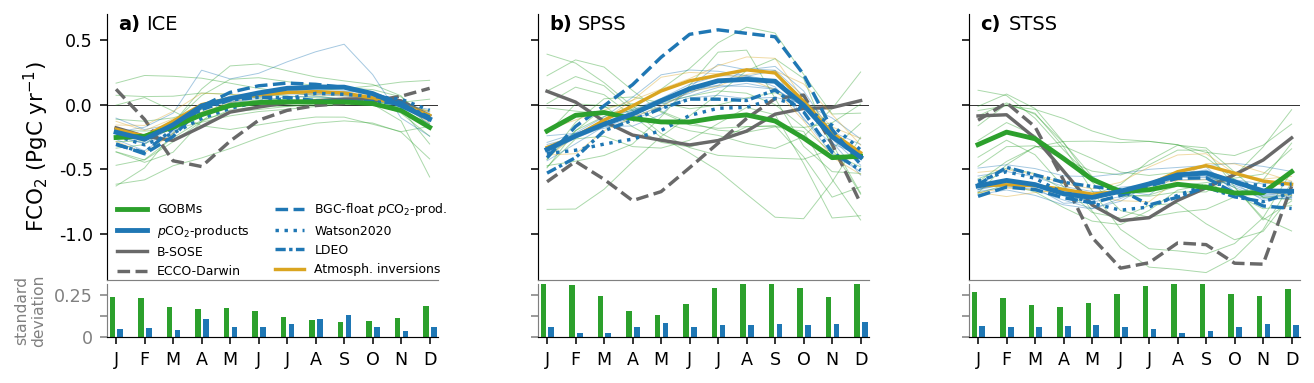

In [16]:
#-----
# plot: 3 subregions
#-----
#subregions_2 = ('STSS-Atl','STSS-Ind','STSS-Pac',\
#              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
#              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')

factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1

unit = 'CO$_{2}$ flux [Pg C yr$^{-1}$]'

plot_members=True
if plot_members: 
    filename1 = 'fig6_seasonal_cycle_CO2_flux_avg_'+\
            str(year1)+'_'+str(year2)+'_wShading_std_PgC_3regions_wMembers_FINAL'
else: 
    filename1 = 'fig6_seasonal_cycle_CO2_flux_avg_'+\
            str(year1)+'_'+str(year2)+'_wShading_std_PgC_3regions_FINAL'
            
            
models_no_MPI = [] #Initialize result list.
for index in ind_not_mpi:
    models_no_MPI.append(models[index]) 
    
# load regional integrals of LDEO (provided by Luke)
ff = Dataset(path_data+'LDEO_clim_with_so_fgco2_integrated_LG.nc')
data_reg_ldeo = np.squeeze(ff.variables['fgco2_so_regions'][:,:])
ff.close()

plot_mpi = False

# expected input: data: models x regions x time, data_mean: regions x time
# swap dimensions in arrays
flux_models_subareas_plot     = np.transpose(flux_models_subareas,[1,2,0])[ind_not_mpi,:,:]
flux_data_products_plot       = np.transpose(flux_data_products_subareas,[1,2,0])[1:,:,:]
flux_data_assim_subareas_plot = np.transpose(flux_data_assim_subareas,[1,2,0])
flux_atminv_subareas_plot = np.transpose(flux_atminv_subareas,[1,2,0])
flux_soccom_subareas_plot = np.transpose(flux_soccom_subareas,[1,2,0])
multi_data_watson_mean_plot = np.transpose(multi_data_watson_mean,[1,0])
multi_ldeo_mean_plot = np.transpose(multi_ldeo_mean,[1,0])
multi_soccom_mean_plot = np.transpose(multi_soccom_mean,[1,0])
# plot first 9 subregions
subroutine_plotting_seasonal_cycle_black_blue_wShading_std_3regions(area_mean_watson[9:12],
                                                                    area_mean_soccom[9:12],
                                                multi_data_watson_mean_plot[9:12,:],
                                                multi_soccom_mean_plot[9:12,:],
                                                multi_ldeo_mean_plot[9:12,:],data_reg_ldeo,
                                                biome_area_models[ind_not_mpi,9:12],
                                                    biome_area_data_products[1:,9:12],
                                                    biome_area_data_assim[:,9:12],
                                                    biome_area_atminv[:,9:12],
                                                    biome_area_ldeo[0,9:12],
                                                flux_models_subareas_plot[:,9:12,:],
                                                flux_data_products_plot[:,9:12,:],
                                                flux_data_assim_subareas_plot[:,9:12,:],
                                                flux_atminv_subareas_plot[:,9:12,:],
                                                models_no_MPI,data_prod[1:],data_assim,data_atminv,
                                               eval_time,factor2,unit,year1,year2,
                                       subregions[9:12],save_to_dir,filename1,plot_members,plot_mpi)

#----------
# colors & line types: double-check with bar plot etc
#....


CHECK NUMBERS: annual flux should correspond to bars in Fig. 2
For models: Note that there is no river flux adjustment here!
#######
STSS
#######
#######
SPSS
#######
#######
ICE
#######


<Figure size 1540x420 with 0 Axes>

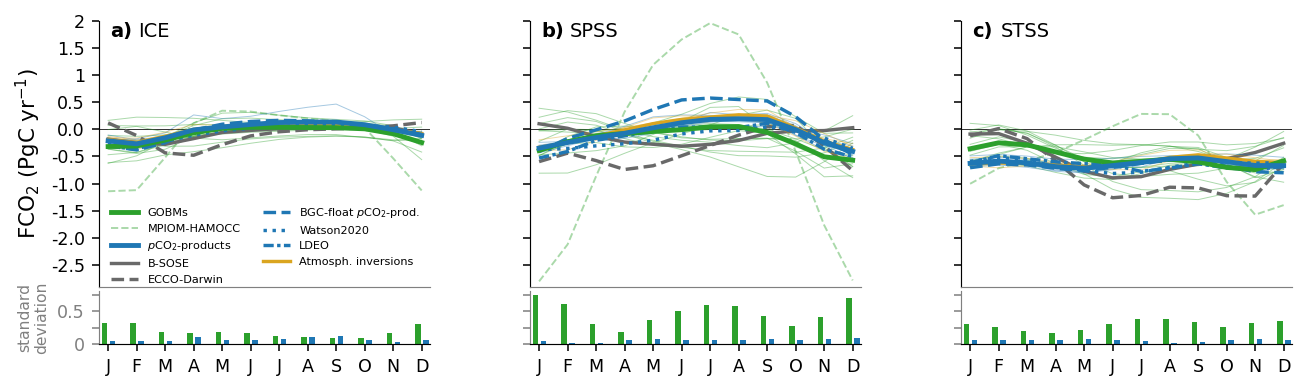

In [17]:
#----
# same but with MPI (for supplement)
#----

#-----
# plot: 3 subregions
#-----
#subregions_2 = ('STSS-Atl','STSS-Ind','STSS-Pac',\
#              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
#              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')

factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1

unit = 'CO$_{2}$ flux [Pg C yr$^{-1}$]'

plot_members=True
if plot_members: 
    filename1 = 'fig6_seasonal_cycle_CO2_flux_avg_'+\
            str(year1)+'_'+str(year2)+'_wShading_std_PgC_3regions_wMembers_FINAL_with_MPI'
else: 
    filename1 = 'fig6_seasonal_cycle_CO2_flux_avg_'+\
            str(year1)+'_'+str(year2)+'_wShading_std_PgC_3regions_FINAL_with_MPI'
            
            
models_no_MPI = [] #Initialize result list.
for index in ind_not_mpi:
    models_no_MPI.append(models[index]) 
    
# load regional integrals of LDEO (provided by Luke)
ff = Dataset(path_data+'LDEO_clim_with_so_fgco2_integrated_LG.nc')
data_reg_ldeo = np.squeeze(ff.variables['fgco2_so_regions'][:,:])
ff.close()

plot_mpi = True

# expected input: data: models x regions x time, data_mean: regions x time
# swap dimensions in arrays
#flux_models_subareas_plot     = np.transpose(flux_models_subareas,[1,2,0])[ind_not_mpi,:,:]
flux_models_subareas_plot     = np.transpose(flux_models_subareas,[1,2,0])[:,:,:]
flux_data_products_plot       = np.transpose(flux_data_products_subareas,[1,2,0])[1:,:,:]
flux_data_assim_subareas_plot = np.transpose(flux_data_assim_subareas,[1,2,0])
flux_atminv_subareas_plot = np.transpose(flux_atminv_subareas,[1,2,0])
flux_soccom_subareas_plot = np.transpose(flux_soccom_subareas,[1,2,0])
multi_data_watson_mean_plot = np.transpose(multi_data_watson_mean,[1,0])
multi_ldeo_mean_plot = np.transpose(multi_ldeo_mean,[1,0])
multi_soccom_mean_plot = np.transpose(multi_soccom_mean,[1,0])
# plot first 9 subregions
subroutine_plotting_seasonal_cycle_black_blue_wShading_std_3regions(area_mean_watson[9:12],
                                                                    area_mean_soccom[9:12],
                                                multi_data_watson_mean_plot[9:12,:],
                                                multi_soccom_mean_plot[9:12,:],
                                                multi_ldeo_mean_plot[9:12,:],data_reg_ldeo,
                                                biome_area_models[:,9:12],
                                                    biome_area_data_products[1:,9:12],
                                                    biome_area_data_assim[:,9:12],
                                                    biome_area_atminv[:,9:12],
                                                    biome_area_ldeo[0,9:12],
                                                flux_models_subareas_plot[:,9:12,:],
                                                flux_data_products_plot[:,9:12,:],
                                                flux_data_assim_subareas_plot[:,9:12,:],
                                                flux_atminv_subareas_plot[:,9:12,:],
                                                models,data_prod[1:],data_assim,data_atminv,
                                               eval_time,factor2,unit,year1,year2,
                                       subregions[9:12],save_to_dir,filename1,plot_members,plot_mpi)

#----------
# colors & line types: double-check with bar plot etc
#....




In [18]:
#---
# EPS version
#---

In [19]:
#---
# plotting routines, EPS version
#---

def subplot_seasonality_eps(ax,ii,counter,panel_labels,subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
    area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all,plot_mpi):
    
    months = ['J','F','M','A','M','J','J','A','S','O','N','D']
    #months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    lw_mean = 2.5
    lw_all = 1
    alpha_value=0.3
    color_models = 'C2'
    color_data   = 'C0'
    color_watson     = 'lightsteelblue'
    color_ldeo =  color_data #'skyblue' #'lightskyblue'
    color_data_assim = 'grey'
    color_data_assim1 = 'dimgrey'
    color_data_assim2 = 'darkgrey'
    color_atminv = 'goldenrod' #'C4'
    color_soccom = 'darkslateblue'
    alpha_std=0.3
    fs_text = 9
    
    color_std = 'grey'
    xlim1,xlim2 = -0.33,11.3 #0.0,11
    ls_ecco = '--'
    ls_soccom = '--'
    ls_watson = ':'
    ls_ldeo = '-.'
    dash_ldeo = [3,1,1,1]    
    
    #-----
    # MODELS
    #-----
    area_monthly = np.transpose(np.tile(biome_area_models,[12,1,1]),[1,2,0])
    model_data_mean = np.nanmean(area_monthly[:,ii,:]*factor*models_all[:,ii,:],axis=0)
    model_data_std = np.nanstd(area_monthly[:,ii,:]*factor*models_all[:,ii,:],axis=0)
    a2a = model_data_mean+model_data_std
    a2b = model_data_mean-model_data_std
    model_data_std1 = np.copy(model_data_std)
    #ax.fill_between(range(0,12), a2a, a2b, color=color_models,alpha = alpha_std,\
    #                 edgecolor='none') 
    if plot_members:
        for dd in range(0,models_all.shape[0]):
            if plot_mpi:
                if models[dd] in ['MPIOM-HAMOCC']:
                    ax.plot(range(0,12),biome_area_models[dd,ii]*factor*models_all[dd,ii,:],\
                        color=color_models, linestyle='--',linewidth=1, alpha=0.4, label='MPIOM-HAMOCC') 
                else:
                    ax.plot(range(0,12),biome_area_models[dd,ii]*factor*models_all[dd,ii,:],\
                        color=color_models, linewidth=0.5)#, alpha=0.4) #ax=ax, hue=dim
            else:
                if models[dd] not in ['MPIOM-HAMOCC']:
                    ax.plot(range(0,12),biome_area_models[dd,ii]*factor*models_all[dd,ii,:],\
                        color=color_models, linewidth=0.5)#, alpha=0.4) #ax=ax, hue=dim
                
                
    ax.plot(range(0,12),model_data_mean,color_models,label='GOBMs',linewidth=lw_mean,zorder=30)
        
    #-----
    # B-SOSE
    #-----
    ax.plot(range(0,12),biome_area_data_assim[0,ii]*factor*data_assim_all[0,ii,:],\
                 color=color_data_assim1, linewidth=lw_mean-0.75, label='B-SOSE')
    ax.plot(range(0,12),biome_area_data_assim[1,ii]*factor*data_assim_all[1,ii,:],\
                 color=color_data_assim1,linestyle=ls_ecco,linewidth=lw_mean-0.75, label=data_assim[1])
        
    #-----
    # DATA
    #-----
    area_monthly = np.transpose(np.tile(biome_area_data_products,[12,1,1]),[1,2,0])
    obs_data_mean = np.nanmean(area_monthly[:,ii,:]*factor*data_all[:,ii,:],axis=0)
    obs_data_std  = np.nanstd(area_monthly[:,ii,:]*factor*data_all[:,ii,:],axis=0)
    a2a = obs_data_mean+obs_data_std
    a2b = obs_data_mean-obs_data_std
    obs_data_std1 = np.copy(obs_data_std)
    #ax.fill_between(range(0,12), a2a, a2b, color=color_data,alpha = alpha_std,\
    #                     edgecolor='none') 
    if plot_members:
        for dd in range(0,data_all.shape[0]):
            ax.plot(range(0,12),biome_area_data_products[dd,ii]*factor*data_all[dd,ii,:],\
                     color=color_data, linewidth=0.5)#, alpha=0.4) #ax=ax, hue=dim
    ax.plot(range(0,12),obs_data_mean,color_data,label='pCO$_{2}$-products',linewidth=lw_mean,zorder=40)
        
    #-----
    # SOCCOM
    #-----
    ax.plot(range(0,12),area_mean_soccom[ii]*factor*data_soccom_mean[ii,:],\
                         color_data,linestyle=ls_soccom,label='BGC-float pCO$_{2}$-prod.',\
            linewidth=lw_mean-0.75,zorder=26)
        
        
    #-----
    # Watson2020
    #-----
    ax.plot(range(0,12),area_mean_watson[ii]*factor*data_watson_mean[ii,:],\
                         color_data,linestyle=ls_watson,label='Watson2020',linewidth=lw_mean-0.75,zorder=25)
        
    
    plot_ldeo = True
    if plot_ldeo:
        #-----
        # LDEO
        #-----
        ax.plot(range(0,12),data_reg_ldeo[ii,:],\
                            color_ldeo,linestyle=ls_ldeo,dashes=dash_ldeo,\
                label='LDEO',linewidth=lw_mean-0.75,zorder=25)
        
    #-----
    # AtmInv
    #-----
    ## atm inv are in PgC m-2 yr-1 already, only multiply by area and change the sign
    #ax.plot(range(0,12),biome_area_atminv[0,ii]*(-1)*data_atminv_all[0,ii,:],\
    #                     color_atminv,label='Atmosph. inversions',linewidth=lw_mean-0.75,zorder=15) #data_atminv[0]
    for dd in range(0,data_atminv_all.shape[0]):
        ax.plot(range(0,12),biome_area_atminv[dd,ii]*(-1)*data_atminv_all[dd,ii,:],\
                         color_atminv,linewidth=0.5,zorder=14) #data_atminv[0] alpha=0.4,
    area_monthly = np.transpose(np.tile(biome_area_atminv,[12,1,1]),[1,2,0])
    aa = area_monthly[:,ii,:]*(-1)*data_atminv_all[:,ii,:]
    ax.plot(range(0,12),np.mean(aa,axis=0),\
                         color_atminv,label='Atmosph. inversions',linewidth=lw_mean-0.75,zorder=15) #data_atminv[0]
    atminv_std1 = np.std(aa,axis=0)
        
    ax.set_xlim((xlim1,xlim2))
    ax.hlines(0,xlim1,xlim2,color='k', linestyle='-', linewidth=0.4, zorder=0)

      
    if plot_mpi:
        # for SUPPL PLOT with MPI
        ax.set_ylim((-2.9,2.0))
        if counter==1: 
            ax.set_yticks([-2.5,-2.0,-1.5,-1.0,-0.5,0.0,0.5,1,1.5,2])
            ax.set_yticklabels([])
        else: 
            ax.set_yticks([-2.5,-2.0,-1.5,-1.0,-0.5,0.0,0.5,1,1.5,2])
            ax.set_yticklabels([])
    else:
        # plot in main text
        ax.set_ylim((-1.35,0.7))
        if counter==1: 
            ax.set_yticks([-1.0,-0.5,0.0,0.5])
            ax.set_yticklabels([])
        else: 
            ax.set_yticks([-1.0,-0.5,0.0,0.5])
            ax.set_yticklabels([])
        
    ax.spines['bottom'].set_color(color_std)
    ax.set_xticks([])
    ax.set_xticklabels([])
        
    return model_data_std1,obs_data_std1,atminv_std1
    


def subroutine_plotting_seasonal_cycle_black_blue_wShading_std_3regions_eps(area_mean_watson,\
                                                                        area_mean_soccom,\
                                                                     data_watson_mean,data_soccom_mean,\
                                                                        data_ldeo_mean,data_reg_ldeo,\
                                                                    biome_area_models,biome_area_data_products,\
                                                                    biome_area_data_assim,biome_area_atminv,\
                                                                    biome_area_ldeo,\
                                                                    models_all,data_all,data_assim_all,\
                                                                        data_atminv_all,\
                                                                     models,data_prod,data_assim,data_atminv,\
                                               eval_time,factor,unit,year1,year2,\
                                       subregions,save_to_dir,filename,plot_members,plot_mpi):
    # data: models x regions x time
    # 
    
    
    
    
    panel_labels = ['c)','b)','a)']

    matplotlib.rcParams['axes.linewidth'] = 0.6 #set the value globally
    plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    
    
    dpicnt = 140
    plt.figure(figsize=(11,3), dpi=dpicnt, facecolor='w', edgecolor='k')#figsize=(9,2)
    
    #----
    # define figure with two rows
    
    print ('CHECK NUMBERS: annual flux should correspond to bars in Fig. 2')
    print ('For models: Note that there is no river flux adjustment here!')
    
    fig, axs = plt.subplots(2,3,figsize=(11,3), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1,1,1],'height_ratios': [1,0.2]})
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.03) 

    ax = axs[0,2]
    ii=0
    counter=3
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std1,obs_data_std1,atminv_std1 = subplot_seasonality_eps(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all,plot_mpi)
    
    
    ax = axs[0,1]
    ii=1
    counter=2
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std2,obs_data_std2,atminv_std2 = subplot_seasonality_eps(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all,plot_mpi)
    
    
    ax = axs[0,0]
    ii=2
    counter=1
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std3,obs_data_std3,atminv_std3 = subplot_seasonality_eps(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all,plot_mpi)
    
    
    #---
    # std
    #---
    width1 = 0.2
    if plot_mpi:
        ylim2a,ylim2b = 0,0.8 # with MPI
    else:
        ylim2a,ylim2b = 0,0.31
    # make sure the settings defined below are the same as in line plots:
    color_std = 'grey'
    color_models = 'C2'
    color_data   = 'C0'
    xlim1,xlim2 = -0.33,11.3
    alpha_std=0.3
    fs_text = 9
    months = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
    ax = axs[1,2]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std1,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std1,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels([])
    #ax.set_ylabel('standard\ndeviation',color=color_std,fontsize=fs_text-1)
    ax.set_ylim((ylim2a,ylim2b))
    if plot_mpi:
        ax.set_yticks([0,0.25,0.5,0.75])
        ax.set_yticklabels([])
    else:
        ax.set_yticks([0,0.125,0.25])
        ax.set_yticklabels([])
        
    ax = axs[1,1]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std2,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std2,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels([])
    ax.set_ylim((ylim2a,ylim2b))
    if plot_mpi:
        ax.set_yticks([0,0.25,0.5,0.75])
    else:
        ax.set_yticks([0,0.125,0.25])
    ax.set_yticklabels([])
    
    ax = axs[1,0]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std3,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std3,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels([])
    ax.set_ylim((ylim2a,ylim2b))
    if plot_mpi:
        ax.set_yticks([0,0.25,0.5,0.75])
        ax.set_yticklabels([])
    else:
        ax.set_yticks([0,0.125,0.25])
        ax.set_yticklabels([])
    
    plt.savefig(save_to_dir+filename+'.eps', bbox_inches='tight',dpi=150, transparent=False,format='eps')   
    plt.show()
    
    
    
    

CHECK NUMBERS: annual flux should correspond to bars in Fig. 2
For models: Note that there is no river flux adjustment here!
#######
STSS
#######
#######
SPSS
#######
#######
ICE
#######


<Figure size 1540x420 with 0 Axes>

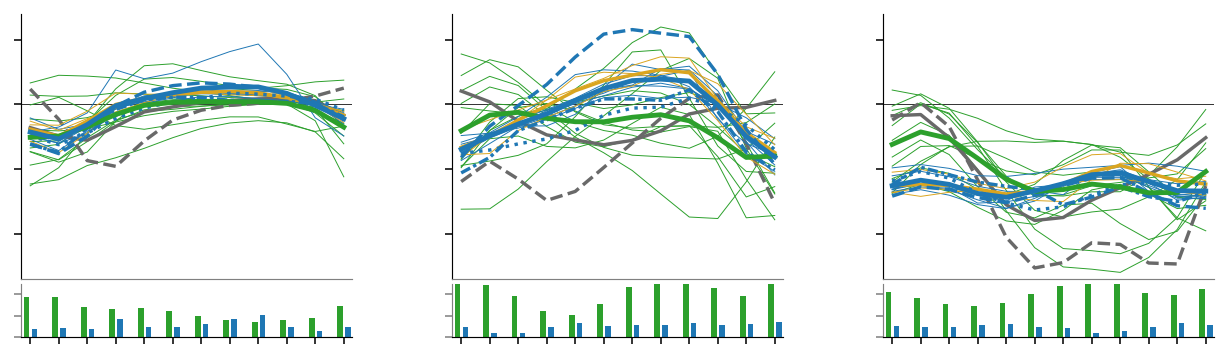

In [20]:
#-----
# plot: 3 subregions, EPS VERSION
#-----
#subregions_2 = ('STSS-Atl','STSS-Ind','STSS-Pac',\
#              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
#              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')

factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1

unit = 'CO$_{2}$ flux [Pg C yr$^{-1}$]'

plot_members=True
if plot_members: 
    filename1 = 'fig6_seasonal_cycle_CO2_flux_avg_'+\
            str(year1)+'_'+str(year2)+'_wShading_std_PgC_3regions_wMembers_FINAL'
else: 
    filename1 = 'fig6_seasonal_cycle_CO2_flux_avg_'+\
            str(year1)+'_'+str(year2)+'_wShading_std_PgC_3regions_FINAL'
            
            
models_no_MPI = [] #Initialize result list.
for index in ind_not_mpi:
    models_no_MPI.append(models[index]) 
    
# load regional integrals of LDEO (provided by Luke)
ff = Dataset(path_data+'LDEO_clim_with_so_fgco2_integrated_LG.nc')
data_reg_ldeo = np.squeeze(ff.variables['fgco2_so_regions'][:,:])
ff.close()

plot_mpi = False

# expected input: data: models x regions x time, data_mean: regions x time
# swap dimensions in arrays
flux_models_subareas_plot     = np.transpose(flux_models_subareas,[1,2,0])[ind_not_mpi,:,:]
flux_data_products_plot       = np.transpose(flux_data_products_subareas,[1,2,0])[1:,:,:]
flux_data_assim_subareas_plot = np.transpose(flux_data_assim_subareas,[1,2,0])
flux_atminv_subareas_plot = np.transpose(flux_atminv_subareas,[1,2,0])
flux_soccom_subareas_plot = np.transpose(flux_soccom_subareas,[1,2,0])
multi_data_watson_mean_plot = np.transpose(multi_data_watson_mean,[1,0])
multi_ldeo_mean_plot = np.transpose(multi_ldeo_mean,[1,0])
multi_soccom_mean_plot = np.transpose(multi_soccom_mean,[1,0])
# plot first 9 subregions
subroutine_plotting_seasonal_cycle_black_blue_wShading_std_3regions_eps(area_mean_watson[9:12],
                                                                    area_mean_soccom[9:12],
                                                multi_data_watson_mean_plot[9:12,:],
                                                multi_soccom_mean_plot[9:12,:],
                                                multi_ldeo_mean_plot[9:12,:],data_reg_ldeo,
                                                biome_area_models[ind_not_mpi,9:12],
                                                    biome_area_data_products[1:,9:12],
                                                    biome_area_data_assim[:,9:12],
                                                    biome_area_atminv[:,9:12],
                                                    biome_area_ldeo[0,9:12],
                                                flux_models_subareas_plot[:,9:12,:],
                                                flux_data_products_plot[:,9:12,:],
                                                flux_data_assim_subareas_plot[:,9:12,:],
                                                flux_atminv_subareas_plot[:,9:12,:],
                                                models_no_MPI,data_prod[1:],data_assim,data_atminv,
                                               eval_time,factor2,unit,year1,year2,
                                       subregions[9:12],save_to_dir,filename1,plot_members,plot_mpi)

#----------
# colors & line types: double-check with bar plot etc
#....


In [21]:
#---
# same updated plot for 9 subregions (supplement)
#---

def subplot_seasonality_without_LDEO(ax,ii,counter,panel_labels,subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
    area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all):
    
    months = ['J','F','M','A','M','J','J','A','S','O','N','D']
    #months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    lw_mean = 2.5
    lw_all = 1
    alpha_value=0.3
    color_models = 'C2'
    color_data   = 'C0'
    color_watson     = 'lightsteelblue'
    color_ldeo =  color_data #'skyblue' #'lightskyblue'
    color_data_assim = 'grey'
    color_data_assim1 = 'dimgrey'
    color_data_assim2 = 'darkgrey'
    color_atminv = 'goldenrod' #'C4'
    color_soccom = 'darkslateblue'
    alpha_std=0.3
    fs_text = 9
    
    color_std = 'grey'
    xlim1,xlim2 = -0.33,11.3 #0.0,11
    ls_ecco = '--'
    ls_soccom = '--'
    ls_watson = ':'
    ls_ldeo = '-.'
    dash_ldeo = [3,1,1,1]    
    
    #-----
    # MODELS
    #-----
    area_monthly = np.transpose(np.tile(biome_area_models,[12,1,1]),[1,2,0])
    model_data_mean = np.nanmean(area_monthly[:,ii,:]*factor*models_all[:,ii,:],axis=0)
    model_data_std = np.nanstd(area_monthly[:,ii,:]*factor*models_all[:,ii,:],axis=0)
    a2a = model_data_mean+model_data_std
    a2b = model_data_mean-model_data_std
    model_data_std1 = np.copy(model_data_std)
    #ax.fill_between(range(0,12), a2a, a2b, color=color_models,alpha = alpha_std,\
    #                 edgecolor='none') 
    if plot_members:
        for dd in range(0,models_all.shape[0]):
            ax.plot(range(0,12),biome_area_models[dd,ii]*factor*models_all[dd,ii,:],\
                    color=color_models, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
    ax.plot(range(0,12),model_data_mean,color_models,label='GOBMs',linewidth=lw_mean,zorder=30)
        
    #-----
    # B-SOSE
    #-----
    ax.plot(range(0,12),biome_area_data_assim[0,ii]*factor*data_assim_all[0,ii,:],\
                 color=color_data_assim1, linewidth=lw_mean-0.75, label='B-SOSE')
    ax.plot(range(0,12),biome_area_data_assim[1,ii]*factor*data_assim_all[1,ii,:],\
                 color=color_data_assim1,linestyle=ls_ecco,linewidth=lw_mean-0.75, label=data_assim[1])
        
    #-----
    # DATA
    #-----
    area_monthly = np.transpose(np.tile(biome_area_data_products,[12,1,1]),[1,2,0])
    obs_data_mean = np.nanmean(area_monthly[:,ii,:]*factor*data_all[:,ii,:],axis=0)
    obs_data_std  = np.nanstd(area_monthly[:,ii,:]*factor*data_all[:,ii,:],axis=0)
    a2a = obs_data_mean+obs_data_std
    a2b = obs_data_mean-obs_data_std
    obs_data_std1 = np.copy(obs_data_std)
    #ax.fill_between(range(0,12), a2a, a2b, color=color_data,alpha = alpha_std,\
    #                     edgecolor='none') 
    if plot_members:
        for dd in range(0,data_all.shape[0]):
            ax.plot(range(0,12),biome_area_data_products[dd,ii]*factor*data_all[dd,ii,:],\
                     color=color_data, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
    ax.plot(range(0,12),obs_data_mean,color_data,label='$p$CO$_{2}$-products',linewidth=lw_mean,zorder=40)
        
    #-----
    # SOCCOM
    #-----
    ax.plot(range(0,12),area_mean_soccom[ii]*factor*data_soccom_mean[ii,:],\
                         color_data,linestyle=ls_soccom,label='BGC-float $p$CO$_{2}$-prod.',\
            linewidth=lw_mean-0.75,zorder=26)
        
        
    #-----
    # Watson2020
    #-----
    ax.plot(range(0,12),area_mean_watson[ii]*factor*data_watson_mean[ii,:],\
                         color_data,linestyle=ls_watson,label='Watson2020',linewidth=lw_mean-0.75,zorder=25)
        
    
    plot_ldeo = False # don't have that for the 9 subregions!!!!
    if plot_ldeo:
        #-----
        # LDEO
        #-----
        ax.plot(range(0,12),data_reg_ldeo[ii,:],\
                            color_ldeo,linestyle=ls_ldeo,dashes=dash_ldeo,\
                label='LDEO',linewidth=lw_mean-0.75,zorder=25)
        
    #-----
    # AtmInv
    #-----
    # atm inv are in PgC m-2 yr-1 already, only multiply by area and change the sign
    for dd in range(0,data_atminv_all.shape[0]):
        ax.plot(range(0,12),biome_area_atminv[dd,ii]*(-1)*data_atminv_all[dd,ii,:],\
                         color_atminv,linewidth=0.5,alpha=0.4,zorder=14) #data_atminv[0]
    area_monthly = np.transpose(np.tile(biome_area_atminv,[12,1,1]),[1,2,0])
    aa = area_monthly[:,ii,:]*(-1)*data_atminv_all[:,ii,:]
    ax.plot(range(0,12),np.mean(aa,axis=0),\
                         color_atminv,label='Atmosph. inversions',linewidth=lw_mean-0.75,zorder=15) #data_atminv[0]
    atminv_std1 = np.std(aa,axis=0)
      
        
    ax.set_xlim((xlim1,xlim2))
    ax.hlines(0,xlim1,xlim2,color='k', linestyle='-', linewidth=0.4, zorder=0)
    
    
   # print counter
    if counter<=3: # 1st row
        ax.set_ylim((-0.65,0.15))
        if counter==1: 
            ax.set_yticks([-0.6,-0.4,-0.2,0.0])
            ax.set_yticklabels(['',-0.4,'',0.0])
        else: 
            ax.set_yticks([-0.6,-0.4,-0.2,0.0])
            ax.set_yticklabels([])
    elif (counter>3) & (counter<=6): # 2nd row
        ax.set_ylim((-0.4,0.4))
        if counter==4: 
            ax.set_yticks([-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4])
            ax.set_yticklabels(['',-0.3,'','',0,'','',0.3,'']) #
        else: 
            ax.set_yticks([-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4])
            ax.set_yticklabels([])
    elif counter>6: # 3rd row: ICE
        ax.set_ylim((-0.25,0.2))
        if counter==7: 
            ax.set_yticks([-0.2,-0.1,0,0.1,0.2])
            ax.set_yticklabels([-0.2,'',0,'',0.2])
        else: 
            ax.set_yticks([-0.2,-0.1,0,0.1,0.2])
            ax.set_yticklabels([])
                
    #ax.set_ylim((-1.35,0.7))
    #if counter==1: 
    #    ax.set_yticks([-1.0,-0.5,0.0,0.5])
    #    ax.set_yticklabels([-1.0,-0.5,0.0,0.5])
    #else: 
    #    ax.set_yticks([-1.0,-0.5,0.0,0.5])
    #    ax.set_yticklabels([])
        
    if (counter==1) | (counter==4) | (counter==7):
        ax.set_ylabel('FCO$_2$ (PgC yr$^{-1}$)',fontsize=fs_text+2)
    
    ax.spines['bottom'].set_color(color_std)
    ax.set_xticks([])#np.arange(0,12))
    ax.set_xticklabels([])
    
    for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)
    for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
    
    if counter==3:
        handles, labels = ax.get_legend_handles_labels() 
        #order = [0,3,1,2,4,5,6,7] ##specify order of items in legend
        order = [0,3,1,2,4,5,6] ##specify order of items in legend
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
                  loc='right',bbox_to_anchor=(0.85, 0.17), \
                ncol=2,fancybox=False,frameon=False,shadow=False,prop={'size': 5},handlelength=2.4) 
    
    ax.annotate(panel_labels[ii],xy=(0.035,0.9), xycoords='axes fraction',
                     fontsize=fs_text+1,fontweight='bold')
    ax.annotate(subregions[ii],xy=(0.12,0.9), xycoords='axes fraction',fontsize=fs_text+1)
    
    return model_data_std1,obs_data_std1,atminv_std1

def subroutine_plotting_seasonal_cycle_black_blue_wShading_std_9regions(area_mean_watson,\
                                                                        area_mean_soccom,\
                                                                     data_watson_mean,data_soccom_mean,\
                                                                        data_ldeo_mean,data_reg_ldeo,\
                                                                    biome_area_models,biome_area_data_products,\
                                                                    biome_area_data_assim,biome_area_atminv,\
                                                                    biome_area_ldeo,\
                                                                    models_all,data_all,data_assim_all,\
                                                                        data_atminv_all,\
                                                                     models,data_prod,data_assim,data_atminv,\
                                               eval_time,factor,unit,year1,year2,\
                                       subregions,save_to_dir,filename,plot_members):
    # data: models x regions x time
    # 
    
    
    
    
    panel_labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']

    matplotlib.rcParams['axes.linewidth'] = 0.6 #set the value globally
    plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    
    
    dpicnt = 140
    plt.figure(figsize=(11,7), dpi=dpicnt, facecolor='w', edgecolor='k')#figsize=(9,2)
    
    #----
    # define figure with three rows
    
    print ('CHECK NUMBERS: annual flux should correspond to bars in Fig. 2')
    print ('For models: Note that there is no river flux adjustment here!')
    
    fig, axs = plt.subplots(8,3,figsize=(11,8), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1,1,1],'height_ratios': [1,0.2,0.2,1,0.2,0.2,1,0.2]})
    
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.09)  # 0.03

    ax = axs[2,0]
    ax.set_axis_off()
    ax = axs[2,1]
    ax.set_axis_off()
    ax = axs[2,2]
    ax.set_axis_off()
    
    ax = axs[5,0]
    ax.set_axis_off()
    ax = axs[5,1]
    ax.set_axis_off()
    ax = axs[5,2]
    ax.set_axis_off()
    
    #------
    # top row: STSS
    #------
    
    ax = axs[0,0]
    ii=0
    counter=1
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std1,obs_data_std1,atminv_std1 = subplot_seasonality_without_LDEO(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all)
    
    
    ax = axs[0,1]
    ii=1
    counter=2
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std2,obs_data_std2,atminv_std2 = subplot_seasonality_without_LDEO(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all)
    
    
    ax = axs[0,2]
    ii=2
    counter=3
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std3,obs_data_std3,atminv_std3 = subplot_seasonality_without_LDEO(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all)
    
    
    
    
    #------
    # middle row: SPSS
    #------
    
    ax = axs[3,0]
    ii=3
    counter=4
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std4,obs_data_std4,atminv_std4 = subplot_seasonality_without_LDEO(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all)
    
    
    ax = axs[3,1]
    ii=4
    counter=5
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std5,obs_data_std5,atminv_std5 = subplot_seasonality_without_LDEO(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all)
    
    
    ax = axs[3,2]
    ii=5
    counter=6
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std6,obs_data_std6,atminv_std6 = subplot_seasonality_without_LDEO(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all)
    
    
    
    #------
    # bottom row: ICE
    #------
    
    ax = axs[6,0]
    ii=6
    counter=7
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std7,obs_data_std7,atminv_std7 = subplot_seasonality_without_LDEO(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all)
    
    
    ax = axs[6,1]
    ii=7
    counter=8
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std8,obs_data_std8,atminv_std8 = subplot_seasonality_without_LDEO(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all)
    
    
    ax = axs[6,2]
    ii=8
    counter=9
    print ('#######')
    print (subregions[ii])
    print ('#######')
    
    model_data_std9,obs_data_std9,atminv_std9 = subplot_seasonality_without_LDEO(ax,ii,counter,panel_labels,\
                                                        subregions,biome_area_models,factor,models_all,\
                       biome_area_data_assim,data_assim_all,biome_area_data_products,data_all,\
                        area_mean_soccom,data_soccom_mean,\
            area_mean_watson,data_watson_mean,data_reg_ldeo,biome_area_atminv,data_atminv_all)
    
    
    #---
    # std
    #---
    width1 = 0.2
    ylim2a,ylim2b = 0,0.21 #0,0.31
    # make sure the settings defined below are the same as in line plots:
    color_std = 'grey'
    color_models = 'C2'
    color_data   = 'C0'
    xlim1,xlim2 = -0.33,11.3
    alpha_std=0.3
    fs_text = 9
    months = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
    yticks1 = [0,0.1,0.2] #[0,0.125,0.25]
    yticks1_label = [0,'',0.2] #[0,'',0.25]
    ylabel1 = 'std' #'standard\ndeviation'
    
    #----
    # std top row: STSS
    #----
    
    ax = axs[1,0]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std1,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std1,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(months)
    ax.set_ylabel(ylabel1,color=color_std,fontsize=fs_text-1)
    ax.set_ylim((ylim2a,ylim2b))
    ax.set_yticks(yticks1)
    ax.set_yticklabels(yticks1_label)
    for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)
    for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
        label.set_color(color_std)
        
    ax = axs[1,1]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std2,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std2,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(months)
    ax.set_ylim((ylim2a,ylim2b))
    ax.set_yticks(yticks1)
    ax.set_yticklabels([])
    for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)
    for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
        label.set_color(color_std)
    
    ax = axs[1,2]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std3,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std3,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(months)
    ax.set_ylim((ylim2a,ylim2b))
    ax.set_yticks(yticks1)
    ax.set_yticklabels([])
    for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)
    for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
        label.set_color(color_std)
        
        
    #----
    # std middle row: SPSS
    #----
    
    ax = axs[4,0]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std4,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std4,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(months)
    ax.set_ylabel(ylabel1,color=color_std,fontsize=fs_text-1)
    ax.set_ylim((ylim2a,ylim2b))
    ax.set_yticks(yticks1)
    ax.set_yticklabels(yticks1_label)
    for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)
    for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
        label.set_color(color_std)
        
    ax = axs[4,1]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std5,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std5,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(months)
    ax.set_ylim((ylim2a,ylim2b))
    ax.set_yticks(yticks1)
    ax.set_yticklabels([])
    for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)
    for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
        label.set_color(color_std)
    
    ax = axs[4,2]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std6,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std6,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(months)
    ax.set_ylim((ylim2a,ylim2b))
    ax.set_yticks(yticks1)
    ax.set_yticklabels([])
    for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)
    for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
        label.set_color(color_std)
        
        
        
    #----
    # std bottom row: ICE
    #----
    
    ax = axs[7,0]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std7,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std7,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(months)
    ax.set_ylabel(ylabel1,color=color_std,fontsize=fs_text-1)
    ax.set_ylim((ylim2a,ylim2b))
    ax.set_yticks(yticks1)
    ax.set_yticklabels(yticks1_label)
    for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)
    for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
        label.set_color(color_std)
        
    ax = axs[7,1]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std8,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std8,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(months)
    ax.set_ylim((ylim2a,ylim2b))
    ax.set_yticks(yticks1)
    ax.set_yticklabels([])
    for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)
    for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
        label.set_color(color_std)
    
    ax = axs[7,2]
    ax.spines['left'].set_color(color_std)
    ax.yaxis.label.set_color(color_std)
    ax.tick_params(axis='y', colors=color_std)
    ax.bar(np.arange(-0.125,11.875,1),model_data_std9,color=color_models,width=width1)
    ax.bar(np.arange(0.15,12.15,1),obs_data_std9,color=color_data,width=width1)
    ax.set_xlim((xlim1,xlim2))
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(months)
    ax.set_ylim((ylim2a,ylim2b))
    ax.set_yticks(yticks1)
    ax.set_yticklabels([])
    for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text)
    for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text)
        label.set_color(color_std)
    
    
    plt.savefig(save_to_dir+filename+'.png', bbox_inches='tight',dpi=150, transparent=False,format='png')   
    plt.savefig(save_to_dir+filename+'.pdf', bbox_inches='tight',dpi=150, transparent=False,format='pdf')   
    plt.show()
    



CHECK NUMBERS: annual flux should correspond to bars in Fig. 2
For models: Note that there is no river flux adjustment here!
#######
STSS-Atl
#######
#######
STSS-Ind
#######
#######
STSS-Pac
#######
#######
SPSS-Atl
#######
#######
SPSS-Ind
#######
#######
SPSS-Pac
#######
#######
ICE-Atl
#######
#######
ICE-Ind
#######
#######
ICE-Pac
#######


<Figure size 1540x980 with 0 Axes>

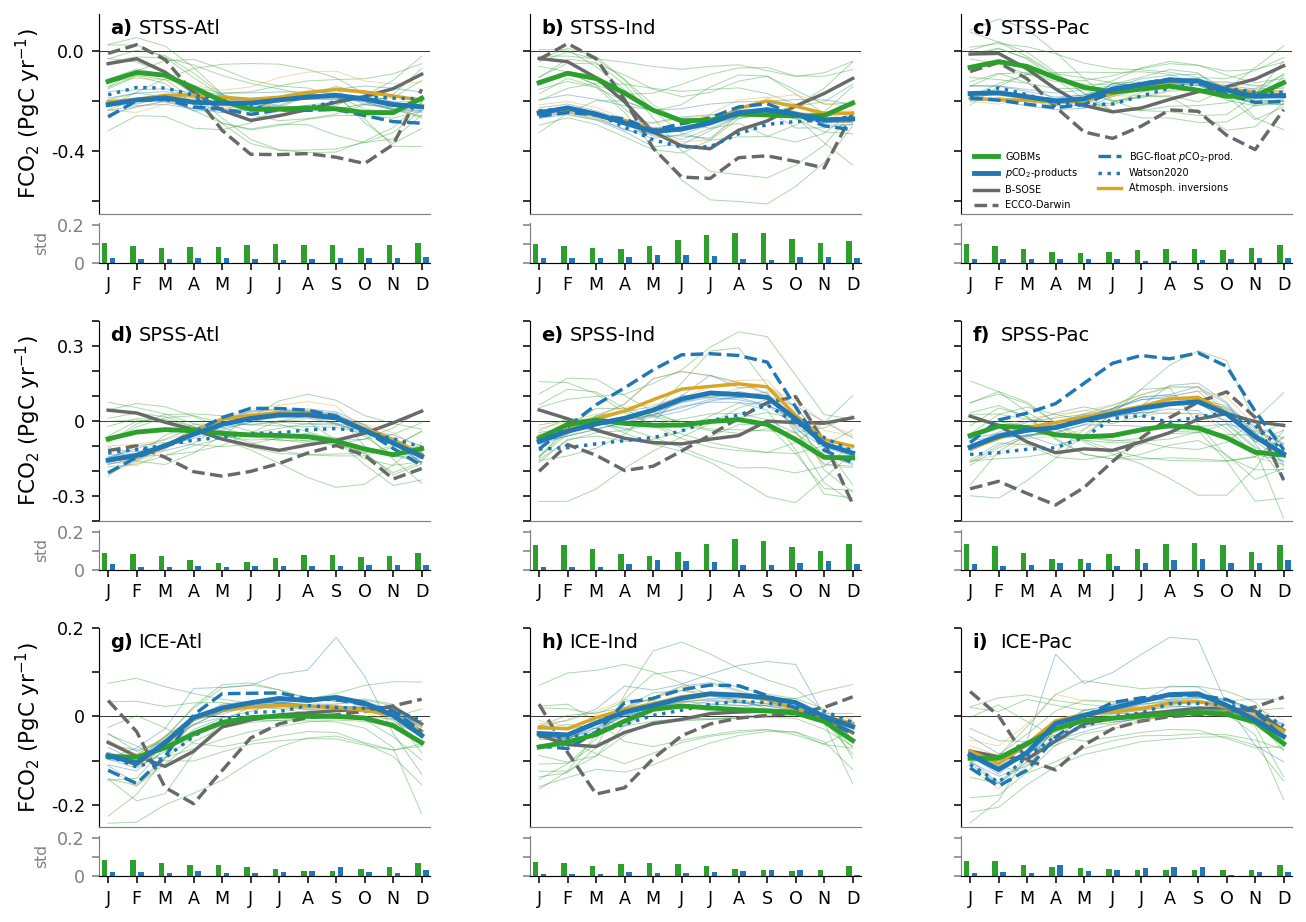

In [22]:
#-----
# plot: 9 subregions
#-----
#subregions_2 = ('STSS-Atl','STSS-Ind','STSS-Pac',\
#              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
#              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')

factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1

unit = 'CO$_{2}$ flux [Pg C yr$^{-1}$]'

plot_members=True
if plot_members: 
    filename1 = 'fig6_seasonal_cycle_CO2_flux_avg_'+\
            str(year1)+'_'+str(year2)+'_wShading_std_PgC_9regions_wMembers_FINAL'
else: 
    filename1 = 'fig6_seasonal_cycle_CO2_flux_avg_'+\
            str(year1)+'_'+str(year2)+'_wShading_std_PgC_9regions_FINAL'
            
            
models_no_MPI = [] #Initialize result list.
for index in ind_not_mpi:
    models_no_MPI.append(models[index]) 
    
# load regional integrals of LDEO (provided by Luke)
ff = Dataset(path_data+'LDEO_clim_with_so_fgco2_integrated_LG.nc')
data_reg_ldeo = np.squeeze(ff.variables['fgco2_so_regions'][:,:])
ff.close()

# expected input: data: models x regions x time, data_mean: regions x time
# swap dimensions in arrays
flux_models_subareas_plot     = np.transpose(flux_models_subareas,[1,2,0])[ind_not_mpi,:,:]
flux_data_products_plot       = np.transpose(flux_data_products_subareas,[1,2,0])[1:,:,:]
flux_data_assim_subareas_plot = np.transpose(flux_data_assim_subareas,[1,2,0])
flux_atminv_subareas_plot = np.transpose(flux_atminv_subareas,[1,2,0])
flux_soccom_subareas_plot = np.transpose(flux_soccom_subareas,[1,2,0])
multi_data_watson_mean_plot = np.transpose(multi_data_watson_mean,[1,0])
multi_ldeo_mean_plot = np.transpose(multi_ldeo_mean,[1,0])
multi_soccom_mean_plot = np.transpose(multi_soccom_mean,[1,0])
# plot first 9 subregions
# NOTE: LDEO is only available for the avg over the 3 biomes! comment in plotting function
subroutine_plotting_seasonal_cycle_black_blue_wShading_std_9regions(area_mean_watson[0:9],
                                                                    area_mean_soccom[0:9],
                                                multi_data_watson_mean_plot[0:9,:],
                                                multi_soccom_mean_plot[0:9,:],
                                                multi_ldeo_mean_plot[0:9,:],data_reg_ldeo,
                                                biome_area_models[ind_not_mpi,0:9],
                                                    biome_area_data_products[1:,0:9],
                                                    biome_area_data_assim[:,0:9],
                                                    biome_area_atminv[:,0:9],
                                                    biome_area_ldeo[0,:], 
                                                flux_models_subareas_plot[:,0:9,:],
                                                flux_data_products_plot[:,0:9,:],
                                                flux_data_assim_subareas_plot[:,0:9,:],
                                                flux_atminv_subareas_plot[:,0:9,:],
                                                models_no_MPI,data_prod[1:],data_assim,data_atminv,
                                               eval_time,factor2,unit,year1,year2,
                                       subregions[0:9],save_to_dir,filename1,plot_members)

#----------
# colors & line types: double-check with bar plot etc
#....



In [23]:
#----
# how different is seasonal amplitude in MPI compared to other models?
#----

print (models)
print (flux_models_subareas.shape)
factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1
ff = 1000

region_1 = 'all'
rr = subregions.index(region_1)
print ('######')
print (region_1)
print ('######')
ampl = [0]
ampl_mpi = [0]
for mm in range(0,len(models)):
    # note: minimum uptake = maximum number (uptake is negative)
    min_uptake = np.max(factor2*biome_area_models[mm,rr]*flux_models_subareas[:,mm,rr])
    max_uptake = np.min(factor2*biome_area_models[mm,rr]*flux_models_subareas[:,mm,rr])
    print (models[mm]+': '+str(np.round(ff*(max_uptake-min_uptake))/ff)+' (Min='+\
            str(np.round(ff*min_uptake)/ff)+', Max='+str(np.round(ff*max_uptake)/ff)+')')
    if models[mm] not in ['MPIOM-HAMOCC']:
        ampl = ampl + (max_uptake-min_uptake)
    else:
        ampl_mpi = (max_uptake-min_uptake)
ampl = ampl/(len(models)-1)
print ('----')
print ('mean amplitude for all except MPI:',ampl[0])
print ('MPI:',ampl_mpi)
print ('Ratio:',ampl_mpi/ampl[0])
print ('----' )       
        
region_1 = 'STSS'
rr = subregions.index(region_1)
print ('######')
print (region_1)
print ('######')
ampl = [0]
ampl_mpi = [0]
for mm in range(0,len(models)):
    # note: minimum uptake = maximum number (uptake is negative)
    min_uptake = np.max(factor2*biome_area_models[mm,rr]*flux_models_subareas[:,mm,rr])
    max_uptake = np.min(factor2*biome_area_models[mm,rr]*flux_models_subareas[:,mm,rr])
    print (models[mm]+': '+str(np.round(ff*(max_uptake-min_uptake))/ff)+' (Min='+\
            str(np.round(ff*min_uptake)/ff)+', Max='+str(np.round(ff*max_uptake)/ff)+')')
    if models[mm] not in ['MPIOM-HAMOCC']:
        ampl = ampl + (max_uptake-min_uptake)
    else:
        ampl_mpi = (max_uptake-min_uptake)
ampl = ampl/(len(models)-1)
print ('----')
print ('mean amplitude for all except MPI:',ampl[0])
print ('MPI:',ampl_mpi)
print ('Ratio:',ampl_mpi/ampl[0])
print ('----') 
        
region_1 = 'SPSS'
rr = subregions.index(region_1)
print ('######')
print (region_1)
print ('######')
ampl = [0]
ampl_mpi = [0]
for mm in range(0,len(models)):
    # note: minimum uptake = maximum number (uptake is negative)
    min_uptake = np.max(factor2*biome_area_models[mm,rr]*flux_models_subareas[:,mm,rr])
    max_uptake = np.min(factor2*biome_area_models[mm,rr]*flux_models_subareas[:,mm,rr])
    print (models[mm]+': '+str(np.round(ff*(max_uptake-min_uptake))/ff)+' (Min='+\
            str(np.round(ff*min_uptake)/ff)+', Max='+str(np.round(ff*max_uptake)/ff)+')')
    if models[mm] not in ['MPIOM-HAMOCC']:
        ampl = ampl + (max_uptake-min_uptake)
    else:
        ampl_mpi = (max_uptake-min_uptake)
ampl = ampl/(len(models)-1)
print ('----')
print ('mean amplitude for all except MPI:',ampl[0])
print ('MPI:',ampl_mpi)
print ('Ratio:',ampl_mpi/ampl[0])
print ('----')
        
region_1 = 'ICE'
rr = subregions.index(region_1)
print ('######')
print (region_1)
print ('######')
ampl = [0]
ampl_mpi = [0]
for mm in range(0,len(models)):
    # note: minimum uptake = maximum number (uptake is negative)
    min_uptake = np.max(factor2*biome_area_models[mm,rr]*flux_models_subareas[:,mm,rr])
    max_uptake = np.min(factor2*biome_area_models[mm,rr]*flux_models_subareas[:,mm,rr])
    print (models[mm]+': '+str(np.round(ff*(max_uptake-min_uptake))/ff)+' (Min='+\
            str(np.round(ff*min_uptake)/ff)+', Max='+str(np.round(ff*max_uptake)/ff)+')')
    if models[mm] not in ['MPIOM-HAMOCC']:
        ampl = ampl + (max_uptake-min_uptake)
    else:
        ampl_mpi = (max_uptake-min_uptake)
ampl = ampl/(len(models)-1)
print ('----')
print ('mean amplitude for all except MPI:',ampl[0])
print ('MPI:',ampl_mpi)
print ('Ratio:',ampl_mpi/ampl[0]) 
print ('----')



('CCSM-WHOI', 'CESM-ETHZ', 'CNRM-ESM2-1', 'EC-Earth3', 'FESOM_REcoM_HR', 'FESOM_REcoM_LR', 'MOM6-Princeton', 'MPIOM-HAMOCC', 'MRI-ESM2-1', 'NorESM-OC1.2', 'ORCA025-GEOMAR', 'ORCA1-LIM3-PISCES', 'PlankTOM12', 'ROMS-SouthernOcean-ETHZ')
(12, 14, 13)
######
all
######
CCSM-WHOI: -1.146 (Min=0.338, Max=-0.808)
CESM-ETHZ: -1.5 (Min=-0.23, Max=-1.73)
CNRM-ESM2-1: -1.557 (Min=0.573, Max=-0.983)
EC-Earth3: -1.367 (Min=0.585, Max=-0.783)
FESOM_REcoM_HR: -1.147 (Min=-0.625, Max=-1.772)
FESOM_REcoM_LR: -1.317 (Min=-0.21, Max=-1.527)
MOM6-Princeton: -1.289 (Min=-0.273, Max=-1.562)
MPIOM-HAMOCC: -7.82 (Min=2.506, Max=-5.313)
MRI-ESM2-1: -0.636 (Min=-0.305, Max=-0.94)
NorESM-OC1.2: -1.561 (Min=-0.724, Max=-2.285)
ORCA025-GEOMAR: -1.6 (Min=-0.258, Max=-1.858)
ORCA1-LIM3-PISCES: -1.391 (Min=0.095, Max=-1.296)
PlankTOM12: -1.606 (Min=0.182, Max=-1.425)
ROMS-SouthernOcean-ETHZ: -1.635 (Min=-0.138, Max=-1.773)
----
mean amplitude for all except MPI: -1.3655197438343403
MPI: -7.81989023071082
Ratio: 5.726

In [24]:
#-----
# print some numbers
#-----
# NOTE: biome fields still contain AOML & MPI, the corresponding flux fields do not!

print_numbers = False

if print_numbers:
    factor = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1
    # multi data: no AOML
    # multi model: no MPI

    # only those that start in 1990
    data_atminv2 = ['CAMSv20r2','sEXTocNEETv2021','NISMON-CO2'] #,'CTE2021','CMS-Flux','UoE'

    models_wo_MPI = [] #Initialize result list.
    for index in ind_not_mpi:
        models_wo_MPI.append(models[index]) 
    ind_not_MPI = ind_not_mpi

    data_prod2 = data_prod[1:]# exclude AOML
    #print data_prod2

    filename_numbers = 'Fig6_numbers_fgco2_'+str(year1)+'_'+str(year2)+'.txt'
    f = open(save_to_dir+filename_numbers, "a")
    print('Note: AOML not considered for multi-data product mean and for finding min/max',file=f)
    print('Note: MPI not considered for multi-model mean and for finding min/max',file=f)
    print('Note: only those atm. inversions are considered that start in 1990',file=f)
    for rr in range(len(subregions)-1, -1, -1):
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)

        for mm in range(0,12): # loop over months
            print('-----',file=f)
            print(months[mm],file=f)
            print('-----',file=f)
            model_std = np.nanstd(biome_area_models[ind_not_MPI,rr]*factor*flux_models_subareas_plot[:,rr,mm],axis=0)
            model_mean = np.nanmean(biome_area_models[ind_not_MPI,rr]*factor*flux_models_subareas_plot[:,rr,mm],axis=0)

            model_min = np.min(biome_area_models[ind_not_MPI,rr]*factor*flux_models_subareas_plot[:,rr,mm])
            model_month_min = np.argmin(biome_area_models[ind_not_MPI,rr]*factor*flux_models_subareas_plot[:,rr,mm])
            model_max = np.max(biome_area_models[ind_not_MPI,rr]*factor*flux_models_subareas_plot[:,rr,mm])
            model_month_max = np.argmax(biome_area_models[ind_not_MPI,rr]*factor*flux_models_subareas_plot[:,rr,mm])

            data_std = np.nanstd(biome_area_data_products[1:,rr]*factor*flux_data_products_plot[:,rr,mm],axis=0)
            data_mean = np.nanmean(biome_area_data_products[1:,rr]*factor*flux_data_products_plot[:,rr,mm],axis=0)

            data_min = np.min(biome_area_data_products[1:,rr]*factor*flux_data_products_plot[:,rr,mm])
            data_month_min = np.argmin(biome_area_data_products[1:,rr]*factor*flux_data_products_plot[:,rr,mm])
            data_max = np.max(biome_area_data_products[1:,rr]*factor*flux_data_products_plot[:,rr,mm])
            data_month_max = np.argmax(biome_area_data_products[1:,rr]*factor*flux_data_products_plot[:,rr,mm])

            atminv_std = np.nanstd(biome_area_atminv[:,rr]*(-1)*flux_atminv_subareas_plot[:,rr,mm],axis=0)
            atminv_mean = np.nanmean(biome_area_atminv[:,rr]*(-1)*flux_atminv_subareas_plot[:,rr,mm],axis=0)

            atminv_min = np.min(biome_area_atminv[:,rr]*(-1)*flux_atminv_subareas_plot[:,rr,mm])
            atminv_month_min = np.argmin(biome_area_atminv[:,rr]*(-1)*flux_atminv_subareas_plot[:,rr,mm])
            atminv_max = np.max(biome_area_atminv[:,rr]*(-1)*flux_atminv_subareas_plot[:,rr,mm])
            atminv_month_max = np.argmax(biome_area_atminv[:,rr]*(-1)*flux_atminv_subareas_plot[:,rr,mm])

            print('Mean across models:',model_mean,file=f)
            print('Std across models:',model_std,file=f)
            print ('min '+str(model_min)+' in '+str(models_wo_MPI[model_month_min]), file=f)
            print ('max '+str(model_max)+' in '+str(models_wo_MPI[model_month_max]), file=f)
            print('Mean across data products:',data_mean,file=f)
            print('Std across data products:',data_std,file=f)
            print ('min '+str(data_min)+' in '+str(data_prod2[data_month_min]), file=f)
            print ('max '+str(data_max)+' in '+str(data_prod2[data_month_max]), file=f)
            print('Mean across atm. inversions:',atminv_mean,file=f)
            print('Std across atm. inversions:',atminv_std,file=f)
            print ('min '+str(atminv_min)+' in '+str(data_atminv2[atminv_month_min]), file=f)
            print ('max '+str(atminv_max)+' in '+str(data_atminv2[atminv_month_max]), file=f)
        print ('##########', file=f)
        print ('', file=f)

    f.close()


        

In [25]:
# NOTE: biome fields still contain AOML & MPI, the corresponding flux fields do not!
#----
# print each model
#----

if print_numbers:
    filename_numbers = 'Fig6_numbers_fgco2_all_models_'+str(year1)+'_'+str(year2)+'.txt'
    f = open(save_to_dir+filename_numbers, "a")

    for rr in range(len(subregions)-1, -1, -1):
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        print('Min',file=f)
        for mm in range(0,len(models_wo_MPI)): 
            data_min = np.min(biome_area_models[ind_not_mpi,:][mm,rr]*factor*flux_models_subareas_plot[mm,rr,:])
            data_month_min = np.argmin(biome_area_models[ind_not_mpi,:][mm,rr]*factor*flux_models_subareas_plot[mm,rr,:])
            print (models_wo_MPI[mm]+': min '+str(data_min)+' in '+str(months[data_month_min]), file=f)

        print('Max',file=f)
        for mm in range(0,len(models_wo_MPI)): 
            data_max = np.max(biome_area_models[ind_not_mpi,:][mm,rr]*factor*flux_models_subareas_plot[mm,rr,:])
            data_month_max = np.argmax(biome_area_models[ind_not_mpi,:][mm,rr]*factor*flux_models_subareas_plot[mm,rr,:])
            print (models_wo_MPI[mm]+': max '+str(data_max)+' in '+str(months[data_month_max]), file=f)
        print ('##########', file=f)
        print ('', file=f)

    f.close()

    #----
    # print each data product
    #----
    filename_numbers = 'Fig6_numbers_fgco2_all_data_products_'+str(year1)+'_'+str(year2)+'.txt'
    f = open(save_to_dir+filename_numbers, "a")

    for rr in range(len(subregions)-1, -1, -1):
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        print('Min',file=f)
        for mm in range(0,len(data_prod2)): 
            data_min = np.min(biome_area_data_products[1:,:][mm,rr]*factor*flux_data_products_plot[mm,rr,:])
            data_month_min = np.argmin(biome_area_data_products[1:,:][mm,rr]*factor*flux_data_products_plot[mm,rr,:])
            print (data_prod2[mm]+': min '+str(data_min)+' in '+str(months[data_month_min]), file=f)
        print('Max',file=f)
        for mm in range(0,len(data_prod2)): 
            data_max = np.max(biome_area_data_products[1:,:][mm,rr]*factor*flux_data_products_plot[mm,rr,:])
            data_month_max = np.argmax(biome_area_data_products[1:,:][mm,rr]*factor*flux_data_products_plot[mm,rr,:])
            print (data_prod2[mm]+': max '+str(data_max)+' in '+str(months[data_month_max]), file=f)
        print ('##########', file=f)
        print ('', file=f)

    f.close()
    print ('done')
